In [1]:
data_folder = "DirEOS2019"
H_filename = "TABLE_H_TP_v1"
He_filename = "TABLE_HE_TP_v1"
HHe_filename = "TABLEEOS_HHE_TP_Y0.275_v1"
Si_filename = 'EOS_Si.pkl'

In [2]:
import os
import pandas as pd
from scipy import interpolate
from scipy.integrate import solve_ivp
import numpy as np
from scipy.constants import gravitational_constant, Boltzmann
import pickle
import scipy
import matplotlib.pyplot as plt
import time
import matplotlib.ticker as mtick

In [3]:
import logging
if not os.path.exists("log"):
    os.mkdir("log")
logging.basicConfig(filename="log/{}.log".format(time.asctime()), filemode='w', level=logging.DEBUG)

In [4]:
from eostable import *

In [5]:
# read table
# interpolation
# integration (calculate rho(r), calculate m(r), calculate next T, P, m)

In [6]:
# Data Source:
# "A new equation of state for dense hydrogen-helium mixtures"
# Chabrier, Mazevet & Soubiran, ApJ 2019

def read_table(filename):
    '''
    parse the data file for H/He
    input a filename, return a panda dataframe
    '''
    logging.info("Read Table: {}".format(filename))
    
    # read file into pandas dataframe
    with open(filename, 'r') as file:
        file.readline()
        lines = file.readlines()  
        # log T [K]      log P [GPa]   log rho [g/cc] log U [MJ/kg]  log S [MJ/kg/K] 
        # dlrho/dlT_P    dlrho/dlP_T     dlS/dlT_P      dlS/dlP_T       grad_ad
        columns = ["logT", "logP", "logRho", "logU", "logS", 
                   "dlogRho/dlogT", "dlogRho/dlogP", "dlogS/dlogT", "dlogS/dlogP", "grad_ad"]
        df = pd.DataFrame(columns=columns)

        for line in lines:
            line = line.strip().split(" ")
            line = [x for x in line if x != ""]

            # ignore logT
            if len(line) == 2: 
                continue

            # read other attribute
            elif len(line) == 10: 
                line = [float(x) for x in line]
                df = df.append(dict(zip(columns, line)), ignore_index=True)

    # convert log value
    df["T"] = 10 ** df["logT"]
    df["P"] = 10 ** df["logP"]
    df["S"] = 10 ** df["logS"]
    df["rho"] = 10 ** df["logRho"]
    
    # convert units
    df["P"] = df["P"] * 1e9 # Gpa --> Pa
    df["rho"] = df["rho"] * 1000 #g/cm^3 --> kg/m^3
    
    # take only part of the columns
    df = df[["T", "P", "S", "rho", "grad_ad"]]
    
    return df


In [7]:
def read_EOS_Si(filename):
    '''
    data from https://github.com/ststewart/aneos-forsterite-2019/blob/master
    '''
    with open(filename, 'rb') as file:
        NewEOS = pickle.load(file)
    return NewEOS
        
def S_curve(NewEOS, Smantle=0.0027):
    '''extract the T-rho-P relation with prescribed S_mantle (unit in MJ/K/kg) from the silicate data
    output:
        df (pd.DataFrame): a dataframe with interpolated T-rho-P relation
    '''
    
    # find the curve
    columns = ["T", "rho", "P", "S"]
    
    mantle_pressure = []
    mantle_temperature = []

    # loop across all densities and extract the values for the requested isentrope
    ForsteriteEOS = NewEOS
    for i in range(0,ForsteriteEOS.ND):
        ind = np.where((ForsteriteEOS.S[:,i] > 0))[0]
        interpfunction = interpolate.interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.P[ind,i]) # MJ/K/kg, GPa
        mantle_pressure = np.append(mantle_pressure,interpfunction(Smantle)) # GPa
        interpfunction = interpolate.interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.T[ind]) # MJ/K/kg, GPa
        mantle_temperature = np.append(mantle_temperature,interpfunction(Smantle)) # GPa

    mantle_density = ForsteriteEOS.rho # g/cm3
    
    df = pd.DataFrame({"T": mantle_temperature, 
                       "rho": mantle_density, 
                       "P": mantle_pressure,
                       "S": np.ones(ForsteriteEOS.ND) * Smantle})
    
    # unit conversion
    df["rho"] = df["rho"] * 1000 #g/cm^3 --> kg/m^3
    df["P"] = df["P"] * 1e9 # (GPa) ---> Pa
    
    return df

In [8]:
def lookup_boundary(num, vals):
    '''given a number and an array, look up the upper and lower closest values from the array
    input:
        num (number): a number
        vals (np.array): an array of shape (n,)
    '''
    sort = vals.argsort()
    idx = np.searchsorted(vals[sort], num, "right")
    lower = vals[sort][idx - 1]
    try:
        upper = vals[sort][idx]
        return lower, upper
    except: # number on the upper boundary
#         logging.debug('Point on the boundary')
        return lower, lower

    
def interpolate_curve(v1, df, target, col1):
    '''interpolate the value of a target attribute from the value of another attribute and a 1D Silicate EOS table
    input:
        v1(number): the value of "another" attibute
        df(pd.DataFrame): the Silicate EOS table
        target(str): name of the column in the Silicate EOS table for the target attribute 
        col1(str): name of the column for v1 
    output:
        S(number): the value of target attribute
        out_of_table(bool): indicate whether the interpolation is out of boundary
    '''
    # set a flag of out of boundary
    out_of_table = False
    
    # lookup the closest T in the EOS table
    T_vals = df[col1].values
    T_lower, T_upper = lookup_boundary(v1, T_vals)
    
    # lookup values
    S_lower = df[df[col1]==T_lower][target].values[0]
    S_upper = df[df[col1]==T_upper][target].values[0]
    
    # interpolate along col2, then col1
    # if reach boundary, return the boundary value
    if v1 > T_upper:
        logging.debug("warning: {} reaches upper bound: {}".format(col1, v1))
        out_of_table = True
        v1 = T_upper
    elif v1 < T_lower:
        logging.debug("warning: {} reaches lower bound: {}".format(col1, v1))
        out_of_table = True
        v1 = T_lower
    S = interpolate.interp1d([T_lower, T_upper], [S_lower, S_upper])(v1)
    
    # convert the output from 1d array to a scalar
    return np.asscalar(S), out_of_table

def interpolate_df(v1, v2, df, target="S", col1="T", col2="P"):
    '''interpolate the value of target attribute from the values of another two attributes and 2D EOS data
    input:
        v1, v2(number): the values of "another" two attributes
        df(pd.DataFrame): 2D silicate EOS data
        target(str): name of the column in the Silicate EOS data for the target attribute 
        col1, col2 (str): names of of the column for v1 and v2, respectively
    output:
        S(number): the target attribute value
        out_of_table(bool): indicate whether the interpolation is out of boundary
    '''
    # set a flag of out of boundary
    out_of_table = False
    
    # lookup the closest T and P value in the EOS table
    T_vals = df[col1].values
    T_lower, T_upper = lookup_boundary(v1, T_vals)
    P_vals1 = df[df[col1]==T_lower][col2].values
    P_vals2 = df[df[col1]==T_upper][col2].values
    P1, P2 = lookup_boundary(v2, P_vals1)
    P3, P4 = lookup_boundary(v2, P_vals2)
    
    # lookup values
    S1 = df[(df[col1]==T_lower) & (df[col2] == P1)][target].values[0]
    S2 = df[(df[col1]==T_lower) & (df[col2] == P2)][target].values[0]
    S3 = df[(df[col1]==T_upper) & (df[col2] == P3)][target].values[0]
    S4 = df[(df[col1]==T_upper) & (df[col2] == P4)][target].values[0]
    
    # interpolate along col2, then col1
    if v2 > P2: 
        logging.debug("warning: {} reaches upper bound: {}".format(col2, v2))
        out_of_table = True
        v2 = P2
    elif v2 < P1:
        logging.debug("warning: {} reaches lower bound: {}".format(col2, v2))
        out_of_table = True
        v2 = P1
    if v2 > P4: 
        logging.debug("warning: {} reaches upper bound: {}".format(col2, v2))
        out_of_table = True
        v2 = P4
    elif v2 < P3:
        logging.debug("warning: {} reaches lower bound: {}".format(col2, v2))
        out_of_table = True
        v2 = P3
    S_lower = interpolate.interp1d([P1, P2], [S1, S2])(v2)
    S_upper = interpolate.interp1d([P3, P4], [S3, S4])(v2)
    
    if v1 > T_upper: 
        logging.debug("warning: {} reaches upper bound: {}".format(col1, v1))
        out_of_table = True
        v1 = T_upper
    elif v1 < T_lower:
        logging.debug("warning: {} reaches lower bound: {}".format(col1, v1))
        out_of_table = True
        v1 = T_lower
    S = interpolate.interp1d([T_lower, T_upper], [S_lower, S_upper])(v1)
    
    # convert the output from 1d array to a scalar
    return np.asscalar(S), out_of_table


def interpolate_S(T, P, NewEOS):
    '''we want to get S value of a given (T, P) combination
    input:
        T(number): temperature
        P(number): pressure
        NewEOS(extEOStable): EOS of Si is an object with T(n), rho(m), P(n*m) and S(n*m), 
        data from https://github.com/ststewart/aneos-forsterite-2019/blob/master
    '''
    # find the T value that is closest to T_given
    T_lower, T_upper = lookup_boundary(T, NewEOS.T)
    T_lower_idx = np.where(NewEOS.T == T_lower)[0][0]
    T_upper_idx = np.where(NewEOS.T == T_upper)[0][0]
    
    # convert pressure unit from Pa to GPa
    P = P / 1e9
    
    # for T_lower and T_upper, find the points which P is closest to P_given, add them to a list
    points = []
    for i in [T_lower_idx, T_upper_idx]:
        P_vector = NewEOS.P[i,:]
        S_vector = NewEOS.S[i,:]
        sort = P_vector.argsort()
        j = np.searchsorted(P_vector[sort], P, "right") - 1
        if j == NewEOS.ND - 1: 
            raise Exception('Error occurred at initialization: P too large, out of range')
        points.append([NewEOS.T[i], NewEOS.rho[sort][j], P_vector[sort][j], S_vector[sort][j]])
        points.append([NewEOS.T[i], NewEOS.rho[sort][j+1], P_vector[sort][j+1], S_vector[sort][j+1]])
    
    # interpolate S and rho
    S_lower = interpolate.interp1d([points[0][2], points[1][2]], [points[0][3], points[1][3]])(P)
    S_upper = interpolate.interp1d([points[2][2], points[3][2]], [points[2][3], points[3][3]])(P)
    S = interpolate.interp1d([T_lower, T_upper], [S_lower, S_upper])(T)
#     rho_lower = interpolate.interp1d([points[0][2], points[1][2]], [points[0][1], points[1][1]])(P)
#     rho_upper = interpolate.interp1d([points[2][2], points[3][2]], [points[2][1], points[3][1]])(P)
#     rho = interpolate.interp1d([T_lower, T_upper], [rho_lower, rho_upper])(T)
    
    # S unit: kJ/K/kg
    
    
    return np.asscalar(S)
    

In [9]:
def log10_linspace(start, stop, num):
    '''create a P array of shape (num,), in the interval [start, stop], with points distributed evenly on log10 scale'''
    log_start = np.log10(start)
    log_stop = np.log10(stop)
    log_array = np.linspace(log_start, log_stop, num)
    array = 10 ** log_array
    return array

def calc_fugacity_coeff(T_b, P_b, EOS_table, gas="H2"):
    ideal_gas_constant = 8.314 # unit in J/mol/K
    num_points = 5000 # number of points for integration
    lower_pressure = 1e6   # lower bound for integration, unit in Pa (1e5 is also fine, but smaller than that lead to large error)
    
    if gas == "H2":
        mol_mass = 0.002 # unit in kg/mol
    elif gas == "He":
        mol_mass = 0.004 # unit in kg/mol
    
    P_array = log10_linspace(lower_pressure, P_b, num_points)
    rho_array = np.zeros_like(P_array)
    
    for (i, P) in enumerate(P_array):
        rho_array[i], out_of_table = interpolate_df(T_b, P, EOS_table, target="rho", col1="T", col2="P")
        if out_of_table:
            raise ValueError("(P, T) is out of table")
    
    # density if it's ideal gas        
    rho_ideal_array = P_array * mol_mass  / (ideal_gas_constant * T_b)
    # degree of compression
    z_array = rho_ideal_array / rho_array
    # (z-1) / p
    partition_function = (z_array - 1) / P_array
    # phi: fugacity coefficient
    ln_phi = np.sum(partition_function[:-1] * np.diff(P_array))
    phi = np.exp(ln_phi)
    
    return phi

def calc_f(P_b, T_b, phi):
    '''calculate solubility (mass fraction), giving the partial pressure, temperature and fugacity coefficient'''
    T0 = 4000     # unit in K
    return 1e-11 * P_b * phi * np.exp(- T0 / T_b)
    
def calc_gas_solubility(P_b, T_b, EOS_H, EOS_He, gas, f_He_env=None):
    '''
    f: mass fraction of dissolved gas in the mantle
    f_He: mass fraction of helium for the dissolved gas
    f_He_env: mass fraction of helium in the envelope
    '''
    if gas == "H2":
        phi = calc_fugacity_coeff(T_b, P_b, EOS_H, gas)
        f = calc_f(P_b, T_b, phi)
        f_He = 0
        
    elif gas == "He":
        phi = calc_fugacity_coeff(T_b, P_b, EOS_He, gas)
        f = calc_f(P_b, T_b, phi)
        f_He = 1
        
    elif gas == "mix":
        if f_He_env is not None:
            P_He = P_b * f_He_env # partial pressure of He
            P_H2 = P_b * (1 - f_He_env) # partial pressure of H2
            phi_H2 = calc_fugacity_coeff(T_b, P_b, EOS_H, "H2")
            phi_He = calc_fugacity_coeff(T_b, P_b, EOS_He, "He")
            x_H2 = calc_f(P_H2, T_b, phi_H2)    # dissolved mass fraction of H2
            x_He = calc_f(P_He, T_b, phi_He)    # dissolved mass fraction of H2
            f = x_H2 + x_He                     # total dissolved mass fraction
            f_He = x_He / f                     # Helium fraction in the dissolved gas
        else:
            raise Exception("Please input mass fraction of helium in the envelope (0<f<1)")
        
    else:
        raise Exception("Please input a correct gas name (H2, He or mix)")
    
    return f, f_He

In [10]:
# integration
def calc_rho(rho_Si, rho_H, rho_He, f, f_He):
    '''calculate the density of silicate, hydrogen and helium mixture, using the linear mixing approximation'''
    if f > 0 and f_He > 0:
        if f_He == 0.275:    # cosmogonic He mass fraction
            return 1.0 / ( (1-f)/rho_Si + f/rho_H )
        else:                # Pure He
            return 1.0 / ( (1-f)/rho_Si + f*(1-f_He)/rho_H + f*f_He/rho_He )
    elif f > 0:              # Pure H
        return 1.0 / ( (1-f)/rho_Si + f/rho_H )
    else:                    # No dissolved gas
        return rho_Si
    
def calc_rho_env(rho_H, rho_He, f_He):
    '''calculate the density of hydrogen and helium mixture, using the linear mixing approximation'''
    if f_He > 0:
        return 1.0 / ( (1-f_He)/rho_H + f_He/rho_He )
    else:
        return rho_H

def calc_c_s(k, T, mu):
    '''calculate sound of speed, input is Boltzmann constant, temperature, mu'''
    m_H = 1.00784 * 1.66 * 1e-27
    return (k * T / mu / m_H) ** (1/2)


# def calc_dT_dr(r, M, T, P, EOS, planet):
#     '''plan A'''
#     G = gravitational_constant
#     k = Boltzmann
#     f_He = planet.f_env_He
#     mu = 1 / ((1 - f_He) / 2 + f_He / 4)
#     c_s = calc_c_s(k, planet.T_eff, mu)
#     lambda_ad_H = planet.Env.interpolate_df_w_flag(T, P, EOS.EOS_H, target="grad_ad")
#     lambda_ad_He = planet.Env.interpolate_df_w_flag(T, P, EOS.EOS_He, target="grad_ad")
    
#     gamma_H = 1 / (1 - lambda_ad_H)
#     gamma_He = 1 / (1 - lambda_ad_He)
#     gamma_mix = ((1 - f_He) * gamma_H / (gamma_H - 1) + f_He * gamma_He / (gamma_He - 1)) \
#             / ((1 - f_He) / (gamma_H - 1) + f_He / (gamma_He - 1))
#     lambda_ad_mix = (gamma_mix - 1 ) / gamma_mix

#     dT_dr = - G * M * T * lambda_ad_mix / r ** 2 / c_s ** 2
#     return dT_dr, planet


def calc_dT_dr(r, M, T, P, dP_dr, EOS, planet, plan="B"):
    ''''''
    if plan == "A":
        G = gravitational_constant
        k = Boltzmann
        f_He = planet.f_env_He
        mu = 1 / ((1 - f_He) / 2 + f_He / 4)
        c_s = calc_c_s(k, planet.T_eff, mu)
        lambda_ad_H = planet.Env.interpolate_df_w_flag(T, P, EOS.EOS_H, target="grad_ad")
        lambda_ad_He = planet.Env.interpolate_df_w_flag(T, P, EOS.EOS_He, target="grad_ad")

        gamma_H = 1 / (1 - lambda_ad_H)
        gamma_He = 1 / (1 - lambda_ad_He)
        gamma_mix = ((1 - f_He) * gamma_H / (gamma_H - 1) + f_He * gamma_He / (gamma_He - 1)) \
                / ((1 - f_He) / (gamma_H - 1) + f_He / (gamma_He - 1))
        lambda_ad_mix = (gamma_mix - 1 ) / gamma_mix

        dT_dr = - G * M * T * lambda_ad_mix / r ** 2 / c_s ** 2
        return dT_dr, planet

    else:
        G = gravitational_constant
        k = Boltzmann
        f_He = planet.f_env_He

        lambda_ad_H = planet.Env.interpolate_df_w_flag(T, P, EOS.EOS_H, target="grad_ad")
        lambda_ad_He = planet.Env.interpolate_df_w_flag(T, P, EOS.EOS_He, target="grad_ad")

        gamma_H = 1 / (1 - lambda_ad_H)
        gamma_He = 1 / (1 - lambda_ad_He)
        gamma_mix = ((1 - f_He) * gamma_H / (gamma_H - 1) + f_He * gamma_He / (gamma_He - 1)) \
                / ((1 - f_He) / (gamma_H - 1) + f_He / (gamma_He - 1))
        lambda_ad_mix = (gamma_mix - 1 ) / gamma_mix

        dT_dr = T * lambda_ad_mix / P * dP_dr
        return dT_dr, planet

def calc_delta_r(delta_M, rho, R):
    '''calculate the thickness of the last layer in the mantle'''
    return delta_M / (4 * np.pi * rho * R ** 2)
        
def calc_rho_Fe(P, rho_Fe_0=8300.00, c=0.00349, n=0.528):
    '''calculate the density of iron core
    formula from Table 3: https://arxiv.org/pdf/0707.2895.pdf'''
    return rho_Fe_0 + c * P ** n

def calc_M_Fe(rho_Fe, R):
    '''calculate the mass of the last layer (actually a sphere) of iron core'''
    return (4/3) * np.pi * R ** 3 * rho_Fe

class value_recorder():
    '''value recorder during the integration'''
    def __init__(self):
        self.r = []
        self.M = []
        self.P = []
        self.rho = []
        self.current_T = None
        self.T = []
        self.out_of_boundary = False
        self.out_of_table = False
        
    def set_T(self, T):
        self.current_T = T
        
    def reset_all(self):
        self.r = []
        self.M = []
        self.P = []
        self.rho = []
        self.current_T = None
        self.T = []
        self.out_of_boundary = False
        self.out_of_table = False
    
    def flag_out_of_table(self, out_of_table):
        if out_of_table:
            self.out_of_table = True
    
    def interpolate_df_w_flag(self, v1, v2, df, target, col1="T", col2="P"):
        target_val, out_of_table = interpolate_df(v1, v2, df, target, col1, col2)
        self.flag_out_of_table(out_of_table)
        return target_val
    
    def interpolate_curve_w_flag(self, v1, df, target, col1):
        target_val, out_of_table = interpolate_curve(v1, df, target, col1)
        self.flag_out_of_table(out_of_table)
        return target_val
    
        
    def sort(self):
        # for the debug use, sort the values according to r
        argsort = np.array(self.r).argsort()
        self.M = list(np.array(self.M)[argsort])
        self.P = list(np.array(self.P)[argsort])
        self.rho = list(np.array(self.rho)[argsort])
        self.T = list(np.array(self.T)[argsort])
        self.current_T = self.T[-1]
        
    def cut_r(self, r):
        idx = np.searchsorted(self.r[::-1], r, "left")
        if idx >= 2:
            self.r = self.r[:-idx+1]
            self.M = self.M[:-idx+1]
            self.P = self.P[:-idx+1]
            self.rho = self.rho[:-idx+1]
            self.T = self.T[:-idx+1]
            self.current_T = self.T[-1]
        
class guess_history():
    '''record the history of R_guess'''
    def __init__(self):
        self.r = []
        self.m_error_pair = [] # when R_guess is too small, we will have m error
        self.r_env_boundary_pair = [] #(R_guess, R_env_boundary)
        
        
class eos_tables():
    def __init__(self):
        pass
    
    def set_gas_table(self, EOS_H, EOS_He, EOS_HHe, EOS_Si_obj):
        self.EOS_H = EOS_H
        self.EOS_He = EOS_He
        self.EOS_HHe = EOS_HHe
        self.EOS_Si_obj = EOS_Si_obj
    
    def get_EOS_Si(self, S_Si):
        self.S_Si = S_Si
        self.EOS_Si = S_curve(self.EOS_Si_obj, S_Si)    
        
        
class Planet():
    def __init__(self, M_core, f_M, X, X_He):
        self.M_core = M_core
        self.f_M = f_M
        
        # calculate the component mass
        self.M_silicate = (1 - f_M) * M_core
        self.M_metal = f_M * M_core
        
        # total gas mass
        self.X = X
        self.X_He = X_He
        self.M_gas = X * self.M_core
        self.M_gas_He = X_He * self.M_gas
        self.M_gas_H = self.M_gas - self.M_gas_He

        self.flag_out_of_table = False
        self.Env = value_recorder()
        self.Mantle = value_recorder()
        self.Metal = value_recorder()
        
    def reset(self):
        self.Env.reset_all()
        self.Mantle.reset_all()
        self.Metal.reset_all()     
    

    def set_f_fHe(self, f, f_He):
        '''update at the end of each loop'''
        self.f = f
        self.f_He = f_He    # note that f_He is the Helium fraction in the dissolved gas
        
        self.M_mantle = self.M_silicate * 1 / (1 - self.f)
        
        self.M_dissolved = self.M_silicate * self.f / (1 - self.f)
        self.M_dissolved_He = self.M_dissolved * self.f_He
        self.M_dissolved_H = self.M_dissolved * (1 - self.f_He)
        
        self.M_env = self.M_gas - self.M_dissolved
        self.M_env_He = self.M_gas_He - self.M_dissolved_He
        self.M_env_H = self.M_gas_H - self.M_dissolved_H
        
        if self.M_env != 0:
            self.f_env_He = self.M_env_He / self.M_env
        else:
            self.f_env_He = 0
        
        # check if the value is larger than zero
        for mass in [self.M_mantle, self.M_dissolved, self.M_dissolved_H, self.M_dissolved_He, 
                     self.M_env, self.M_env_He, self.M_env_H, self.f, self.f_He]:
            if mass < 0:
                raise ValueError(f"Mass update is invalid for f={self.f}, f_He={self.f_He}")
        
        self.calc_total_mass()
    
    def calc_total_mass(self):
        self.M_total = self.M_mantle + self.M_metal + self.M_env
        
    def calc_gas_solubility(self, P_EC, T_EC, EOS):
        if self.X_He == 0: gas = 'H2'
        elif self.X_He == 1: gas = 'He'
        else: gas = 'mix'
        f, f_He = calc_gas_solubility(P_EC, T_EC, EOS.EOS_H, EOS.EOS_He, gas=gas, f_He_env=self.X_He)
        return f, f_He
    

In [11]:
def func_mantle(r, y, EOS, planet):
    '''
    calculate dMdr and dPdr at one layer in the mantle
    input: 
        r (num): radius
        y ([M, P]): a list which contains mass, pressure
        EOS_Si, EOS_H, EOS_He (pd.DataFrame): the EOS table of materials
        M_boundary (number): the mass boundary to switch from mantle to iron core
        S_Si: the constant entropy of silicate
        f: dissolved gas mass fraction
        f_He: He mass fraction
        ValueRecorder (object): a small object to record values in the integration process
    output:
        (dM_dr, dP_dr): a list which contains the differential values
    '''
    # get P, T, M
    M, P = y[0], y[1]
    f, f_He = planet.f, planet.f_He
    T = planet.Mantle.current_T
    G = gravitational_constant
    
    # record values
    planet.Mantle.r.append(r)
    planet.Mantle.M.append(M)
    planet.Mantle.P.append(P)
    planet.Mantle.T.append(T)
                
    # lookup table to acquire the density of silicate
    rho_Si = planet.Mantle.interpolate_curve_w_flag(P, EOS.EOS_Si, target="rho", col1="P")
        
    # initialize the density of H, He
    rho_H, rho_He = 0, 0
    
    if f_He == 0.275:     # cosmogenic composition, directly apply the density of mixture to rho_H
        rho_H = planet.Mantle.interpolate_df_w_flag(T, P, EOS.EOS_HHe, target="rho")
        rho_He = 0
    else:    
        if f > 0:
            rho_H = planet.Mantle.interpolate_df_w_flag(T, P, EOS.EOS_H, target="rho") 
        if f_He > 0:
            rho_He = planet.Mantle.interpolate_df_w_flag(T, P, EOS.EOS_He, target="rho")
    
    # calculate rho
    rho = calc_rho(rho_Si, rho_H, rho_He, f, f_He)  
    
    dM_dr = 4 * np.pi * r **2 * rho
    dP_dr = - G * M * rho / r ** 2
    
    # record the values
    planet.Mantle.current_T = planet.Mantle.interpolate_curve_w_flag(P, EOS.EOS_Si, target="T", col1="P")
    planet.Mantle.rho.append(rho)
    
    return (dM_dr, dP_dr)

def func_metal(r, y, planet):
    '''
    input: 
        r (num): radius
        y ([M, P]): a list which contains mass, pressure
        EOS_Si, EOS_H, EOS_He (pd.DataFrame): the EOS table of the elements
        M_boundary (number): the mass boundary of silicate and metal
        S_Si: the constant entropy of silicate
        f: dissolved gas mass fraction
        f_He: He mass fraction
        ValueRecorder (object): a small object to record values in the integration process
    output:
        (dM_dr, dP_dr): a list which contains the partial differential values
    '''
    # get P, T, M
    M, P = y[0], y[1]
    G = gravitational_constant
    
    # record values
    planet.Metal.r.append(r)
    planet.Metal.M.append(M)
    planet.Metal.P.append(P)
    
    # lookup table
    rho = calc_rho_Fe(P)  
    
    dM_dr = 4 * np.pi * r **2 * rho
    dP_dr = - G * M * rho / r ** 2
    
    # record the values
    planet.Metal.rho.append(rho)
    
    return (dM_dr, dP_dr)


def func_env(r, y, EOS, planet):
    '''
    calculate dMdr and dPdr at one layer in the mantle
    input: 
        r (num): radius
        y ([M, P]): a list which contains mass, pressure
        EOS_H, EOS_He (pd.DataFrame): the EOS table of materials
        M_boundary (number): the mass boundary to switch from mantle to iron core
        f_He: He mass fraction at each layer
        T_eff: upper boundary condition
        ValueRecorder (object): a small object to record values in the integration process
    output:
        (dM_dr, dP_dr, dT_dr): a list which contains the differential values
    '''
    # get P, T, M
    M, P, T = y[0], y[1], y[2]
    G = gravitational_constant
    k = Boltzmann
    
    # record values
    planet.Env.r.append(r)
    planet.Env.M.append(M)
    planet.Env.P.append(P)
    planet.Env.T.append(T)
        
    # initialize the density of H, He
    rho_H, rho_He = 0, 0
    f, f_He = 1, planet.f_env_He
    
    if f_He == 0.275:     # cosmogenic composition, directly apply the density of mixture to rho_H
        rho_H = planet.Env.interpolate_df_w_flag(T, P, EOS.EOS_HHe, target="rho")
        rho_He = 0
    else:    
        if f > 0:         # pure H
            rho_H = planet.Env.interpolate_df_w_flag(T, P, EOS.EOS_H, target="rho") 
        if f_He > 0:      # pure He
            rho_He = planet.Env.interpolate_df_w_flag(T, P, EOS.EOS_He, target="rho")
       
    # calculate rho
    rho = calc_rho_env(rho_H, rho_He, f_He)  
    
    dM_dr = 4 * np.pi * r **2 * rho
    dP_dr = - G * M * rho / r ** 2
    dT_dr, planet = calc_dT_dr(r, M, T, P,dP_dr, EOS, planet, plan="B")
#     dT_dr, planet = calc_dT_dr(r, M, T, P, EOS, planet)
    
    # record the values
    planet.Env.rho.append(rho)
    
    logging.debug('P, T, rho, dM_dr, dP_dr, dT_dr, rho_H: {}, {}, {}, {}, {}, {}, {}'.format(P, T, rho, dM_dr, dP_dr, dT_dr, rho_H)) # ======debugging purpose
    
    return (dM_dr, dP_dr, dT_dr)


In [12]:
def adjust_boundary(ValueRecorder, M_boundary, EOS_Si):
    # adjust the boundary to the accurate r value (larger than the current r)

    delta_M_boundary = M_boundary - ValueRecorder.M[-1]
    rho_boundary = ValueRecorder.rho[-1]
    delta_r_boundary = calc_delta_r(delta_M_boundary, rho_boundary, ValueRecorder.r[-1])
    r_boundary = ValueRecorder.r[-1] + delta_r_boundary   # delta_r_boundary is a positive number
    dP_dr = - gravitational_constant * M_boundary * rho_boundary / ValueRecorder.r[-1] ** 2
    P_boundary = ValueRecorder.P[-1] + dP_dr * delta_r_boundary   # by definition
    
    T_boundary = ValueRecorder.interpolate_curve_w_flag(P_boundary, EOS_Si, target="T", col1="P")
    rho_boundary = ValueRecorder.interpolate_curve_w_flag(P_boundary, EOS_Si, target="rho", col1="P")

    # save the boundary values
    ValueRecorder.r[-1] = r_boundary
    ValueRecorder.M[-1] = M_boundary
    ValueRecorder.P[-1] = P_boundary
    ValueRecorder.T[-1] = T_boundary
    ValueRecorder.rho[-1] = rho_boundary

    logging.info("boundary (r, M, P, T, rho) after adjustment: {}, {}, {}, {}, {}".format(ValueRecorder.r[-1], \
        ValueRecorder.M[-1], ValueRecorder.P[-1], ValueRecorder.T[-1], ValueRecorder.rho[-1]))
    
    return ValueRecorder


def adjust_boundary_env(planet, M_boundary, EOS):
    # adjust the boundary to the accurate r value (larger than the current r)
    ValueRecorder = planet.Env
    
    delta_M_boundary = M_boundary - ValueRecorder.M[-1]
    rho_boundary = ValueRecorder.rho[-1]
    delta_r_boundary = calc_delta_r(delta_M_boundary, rho_boundary, ValueRecorder.r[-1])
    r_boundary = ValueRecorder.r[-1] + delta_r_boundary   # delta_r_boundary is a positive number
    dP_dr = - gravitational_constant * M_boundary * rho_boundary / ValueRecorder.r[-1] ** 2
    P_boundary = ValueRecorder.P[-1] + dP_dr * delta_r_boundary   # by definition
    
    # calculate T_boundary
    dT_dr, planet = calc_dT_dr(ValueRecorder.r[-1], ValueRecorder.M[-1], ValueRecorder.T[-1], ValueRecorder.P[-1], 
                               dP_dr, EOS, planet, plan="B")
    T_boundary = ValueRecorder.T[-1] + dT_dr * delta_r_boundary
       
    # calculate rho_boundary
    rho_H = planet.Env.interpolate_df_w_flag(T_boundary, P_boundary, EOS.EOS_H, target="rho") 
    rho_He = planet.Env.interpolate_df_w_flag(T_boundary, P_boundary, EOS.EOS_He, target="rho") 
    rho_boundary = calc_rho_env(rho_H, rho_He, planet.f_He) 

    # save the boundary values
    ValueRecorder = planet.Env
    ValueRecorder.r[-1] = r_boundary
    ValueRecorder.M[-1] = M_boundary
    ValueRecorder.P[-1] = P_boundary
    ValueRecorder.T[-1] = T_boundary
    ValueRecorder.rho[-1] = rho_boundary

    logging.info("boundary (r, M, P, T, rho) after adjustment: {}, {}, {}, {}, {}".format(ValueRecorder.r[-1], \
        ValueRecorder.M[-1], ValueRecorder.P[-1], ValueRecorder.T[-1], ValueRecorder.rho[-1]))
    
    return ValueRecorder


def evaluate_boundary(ValueRecorder, M_boundary, R_guess, R_guess_max, R_guess_min):
    break_ = False
    
    # process the result
    logging.info("boundary (r, M, P, T, rho) before adjustment: {}, {}, {}, {}, {}".format(ValueRecorder.r[-1], \
        ValueRecorder.M[-1], ValueRecorder.P[-1], ValueRecorder.T[-1], ValueRecorder.rho[-1]))

    # when R_guess is too large, M could be below zero
    if ValueRecorder.M[-1] < 0:
        logging.error("R_guess is too large. Mass reaches zero at the boundary.")
        R_guess_max = R_guess # decrease R_guess  
        break_ = True

    # ??? when R_guess is so small that the integration ends when r reaches 0
    if ValueRecorder.M[-1] > M_boundary:
        logging.error("R_guess is too small. Integration ends before the boundary.")
        R_guess_min = R_guess # increase R_guess
        break_ = True

    if ValueRecorder.M[-1] < M_boundary:
        pass
    
    return break_, R_guess_max, R_guess_min
    

In [13]:
# def integrate(M_core, f, f_He, f_M, R_guess, 
#               T_EC, P_EC, 
#               dr_coeff,
#               EOS_H, EOS_He, EOS_Si_obj, 
#               ValueRecorder, MetalValueRecorder,
#               R_guess_history,
#               R_guess_max = None, R_guess_min = None, 
#               uniform=True, T_jump=False):
#     '''
#     input:
#         M_core: mass of core
#         f: dissolved gas mass fraction
#         f_He: He mass fraction
#         f_M: metal mass fraction
#         R_guess: initial guess of radius
#         T_EC, P_EC: envelope-core boundary condition
#         dr_coeff: a coeffcient to set the maxium possible dr for the RK4 integrator
#         uniform: uniform dissolved gas assumption
#         T_jump: whether there is a temperature jump between the magma ocean and iron core
#         EOS_H, EOS_He: input tables of H and He EOS
#         ValueRecorder, MetalValueRecorder: value recorder of the integration values (for debugging purpose)
#         EOS_Si_obj: input object of silicate EOS
#     '''
#     # append to guess history 
#     R_guess_history.r.append(R_guess)
    
#     # define the range of R_guess to from 0.01*R_guess to 100*R_guess
#     if not R_guess_max:
#         R_guess_max = R_guess * 1e2
#     if not R_guess_min:
#         R_guess_min = R_guess * 1e-2
    
#     # reset the recorder
#     ValueRecorder.reset_all()
#     MetalValueRecorder.reset_all()
    
#     # set the max possible dr for the RK4 integrator
#     dr_max = dr_coeff * R_guess
    
#     # calculate the total mass of each component
#     M_silicate = (1-f_M) * M_core
#     M_metal = f_M * M_core
#     M_mantle = M_silicate / (1-f)
#     M_total = M_mantle + M_metal
    
#     # set the gravitational constant
#     G = gravitational_constant
    
#     # stop integration when r is smaller than 5 * dr
#     r_lim = 5
    
#     # for silicate, get S from T and P at the envelope-mantle boundary
#     S_Si = interpolate_S(T_EC, P_EC, EOS_Si_obj)
#     # then interpolate the EOS_Si with a fixed entropy S_Si
#     EOS_Si = S_curve(EOS_Si_obj, S_Si)
    
#     # interpolate other initial conditions
#     rho_Si, out_of_table = interpolate_curve(P_EC, EOS_Si, target="rho", col1="P")
#     ValueRecorder.flag_out_of_table(out_of_table)
        
#     rho_H, out_of_table = interpolate_df(T_EC, P_EC, EOS_H, target="rho")
#     ValueRecorder.flag_out_of_table(out_of_table)
        
#     rho_He, out_of_table = interpolate_df(T_EC, P_EC, EOS_He, target="rho")
#     ValueRecorder.flag_out_of_table(out_of_table)
    
#     # calculate the density of mixture at the envelope-mantle boundary
#     rho = calc_rho(rho_Si, rho_H, rho_He, f, f_He)
    
# #     print("initial condition (rho, M_total, S_Si): ", rho, M_total, S_Si)
    
#     while True:
#         # integration over the mantle
#         ValueRecorder.set_T(T_EC)
        
#         try: 
#             def reach_boundary(r, y, *args):
#                 return y[0] - M_metal # when mass reaches the iron core boundary, stop integration
#             reach_boundary.terminal = True

#             solve_ivp(func_mantle, 
#                     t_span=(R_guess, r_lim * abs(dr_max)), # integrate from R_guess to 0
#                     y0=(M_total, P_EC), # initial y
#                     method='RK45', # Explicit Runge-Kutta method of order 5(4)
#                     max_step=abs(dr_max), # maximum stepsize is dr
#                     events = [reach_boundary],
#                     args=[EOS_Si, EOS_H, EOS_He, EOS_HHe, M_metal, S_Si, f, f_He, ValueRecorder] # pass in additional args
#                     )
#         except:
#             raise Exception("Integration fails for mantle.")

#         # process the result
#         boundary = len(ValueRecorder.M) - 1 # get the index of t where the M first smaller than M_metal 
#         # ???? may cause some problems
#         logging.info("boundary (r, M, P, T, rho) before adjustment: {}, {}, {}, {}, {}".format(ValueRecorder.r[-1], \
#             ValueRecorder.M[-1], ValueRecorder.P[-1], ValueRecorder.T[-1], ValueRecorder.rho[-1]))
        
#         # when R_guess is too large, M could be below zero
#         if ValueRecorder.M[-1] < 0:
#             logging.error("R_guess is too large. Mass reaches zero at the iron core boundary.")
#             R_guess_max = R_guess # decrease R_guess  
#             break
            
#         # ??? when R_guess is so small that the integration ends when r reaches 0
#         if ValueRecorder.M[-1] > M_metal:
#             logging.error("R_guess is too small. Integration ends before the iron core boundary.")
#             # increase R_guess
#             R_guess_min = R_guess # increase R_guess
#             break

#         # adjust the boundary to the accurate r value (larger than the current r)
#         if ValueRecorder.M[-1] < M_metal:
#             ValueRecorder = adjust_boundary(ValueRecorder, M_metal, EOS_Si)

#         ##### add-in T_jump later

#         # integration for metal core
#         try:
#             def reach_boundary(r, y, *args):
#                 return y[0] # when mass = 0
#             reach_boundary.terminal = True
            
#             solve_ivp(func_metal, 
#                     t_span=(ValueRecorder.r[-1], r_lim * abs(dr_max)), # integrate from R_guess to 0
#                     y0=(M_metal, ValueRecorder.P[-1]), # initial y
#                     method='RK45', # Explicit Runge-Kutta method of order 5(4)
#                     max_step=abs(dr_max), # maximum stepsize is dr
#                     events = [reach_boundary],
#                     args=[0, MetalValueRecorder] # pass in additional args
#                     )
#         except:
#             logging.error("Integration for metal ends at r = {}".format(MetalValueRecorder.r[-1]))
#             raise Exception("Integration fails for metal.")
        
#         # post integration
#         last_r = MetalValueRecorder.r[-1]
#         if last_r > 0:
#             # if the last radius is small enough
#             # calculate the mass for the last bit of metal component
#             MetalValueRecorder.M.append(MetalValueRecorder.M[-1] - \
#                                         calc_M_Fe(MetalValueRecorder.rho[-1], MetalValueRecorder.r[-1]))
#             MetalValueRecorder.r.append(0)
#             MetalValueRecorder.P.append(MetalValueRecorder.P[-1])
#             MetalValueRecorder.rho.append(MetalValueRecorder.rho[-1])

#         # evaluate the error of integration result
#         last_layer_M = MetalValueRecorder.M[-1]
#         error_ratio = last_layer_M / M_core

#         logging.info("M_error / M_core: {}".format(error_ratio))
#         if abs(error_ratio) <= 0.001:
#             if ValueRecorder.out_of_table:
#                 logging.error("Integration finishes out of table, at R={}".format(R_guess))
#                 raise Exception("Integration finishes out of table, at R={}".format(R_guess))
#             else:
#                 logging.info("Integration finishes at {}".format(R_guess))
#                 return R_guess, ValueRecorder, MetalValueRecorder
#         elif error_ratio > 0.001:
#             R_guess_min = R_guess # increase R_guess
#             R_guess_history.m_error_pair.append((R_guess, error_ratio))
#             break
#         else:
#             R_guess_max = R_guess # decrease R_guess  
#             R_guess_history.m_error_pair.append((R_guess, error_ratio))
#             break
            
    
#     # if R_guess needs to be adjusted and re-integrated
#     R_guess_next = np.sqrt(R_guess_max * R_guess_min)        
#     logging.info("\nnew_R_guess: {}".format(R_guess_next))
#     print("new_R_guess: {}".format(R_guess_next))
    
#     results = integrate(M_core, f, f_He, f_M, R_guess_next, 
#               T_EC, P_EC, 
#               dr_coeff,
#               EOS_H, EOS_He, EOS_Si_obj, 
#               ValueRecorder, MetalValueRecorder,
#               R_guess_history,
#               R_guess_max, R_guess_min, 
#               uniform=True, T_jump=False)
    
#     return results
    
    
    

In [14]:
# def integrate_with_atmos(planet,
#                          R_guess, 
#               dr_coeff,
#               EOS, 
#               R_guess_history,
#               R_guess_max = None, R_guess_min = None, 
#               uniform=True, T_jump=False, fugacity=False):
#     '''
#     input:
#         M_core: mass of core 
#         X: envelope mass / core mass # new
#         X_He: Helium mass / envelope mass # new
#         f_M: metal mass / core mass
#         R_guess: initial guess of radius
#         T_eff, P_eff: upper boundary condition # new
#         dr_coeff: a coeffcient to set the maxium possible dr for the RK4 integrator
#         uniform: uniform dissolved gas assumption
#         T_jump: whether there is a temperature jump between the magma ocean and iron core
#         EOS_H, EOS_He: input tables of H and He EOS
#         EnvValueRecorder, ValueRecorder, MetalValueRecorder: value recorder of the integration values (for debugging purpose)
#         EOS_Si_obj: input object of silicate EOS
#         fugacity (bool): whether to consider the fugacity  
#     '''
#     # append to guess history 
#     R_guess_history.r.append(R_guess)
    
#     # define the range of R_guess to from 0.01*R_guess to 100*R_guess
#     if not R_guess_max:
#         R_guess_max = R_guess * 1e2
#     if not R_guess_min:
#         R_guess_min = R_guess * 1e-2
        
#     planet.reset()
    
#     # integration details
#     dr_max = dr_coeff * R_guess # set the max possible dr for the RK4 integrator
#     r_lim = 5 # stop integration when r is smaller than 5 * dr
    
#     # get constants
#     G = gravitational_constant
    
#     while True:
#         # atmostpheric integration
#         try: 
#             def reach_boundary(r, y, *args):
#                 return y[0] - (planet.M_total - planet.M_env) # when mass reaches the iron core boundary, stop integration
#             reach_boundary.terminal = True

#             sol = solve_ivp(func_env, 
#                     t_span=(R_guess, r_lim * abs(dr_max)), # integrate from R_guess to 0
#                     y0=(planet.M_total, planet.P_eff, planet.T_eff), # initial y
#                     method='RK45', # Explicit Runge-Kutta method of order 5(4)
#                     max_step=abs(dr_max), # maximum stepsize is dr
#                     events = [reach_boundary],
#                     args=[EOS, planet] # pass in additional args
#                     )
#         except:
#             raise Exception("Integration fails for envelope.")

#         break_, R_guess_max, R_guess_min = evaluate_boundary(planet.Env, planet.M_total - planet.M_env, R_guess, R_guess_max, R_guess_min)
        
#         if break_:
#             print("Break @ Env")
#             R_guess_history.r_env_boundary_pair.append((R_guess, None)) # ===== debugging purpose
#             break
        
#         planet.Env.cut_r(sol.t_events[0][0])
#         planet.Env = adjust_boundary_env(planet, planet.M_total - planet.M_env, EOS)

#         # get T_EC, P_EC for mantle
#         T_EC = planet.Env.T[-1]
#         P_EC = planet.Env.P[-1]
#         print("T_EC={}, P_EC={}".format(T_EC, P_EC))

#         # for silicate, get S from T and P at the envelope-mantle boundary
#         # then interpolate the EOS_Si with a fixed entropy S_Si
#         S_Si = interpolate_S(T_EC, P_EC, EOS.EOS_Si_obj)
#         EOS.get_EOS_Si(S_Si)

#         # interpolate other initial conditions
#         rho_Si = planet.Mantle.interpolate_curve_w_flag(P_EC, EOS.EOS_Si, target="rho", col1="P")
#         rho_H = planet.Mantle.interpolate_df_w_flag(T_EC, P_EC, EOS.EOS_H, target="rho")    
#         rho_He = planet.Mantle.interpolate_df_w_flag(T_EC, P_EC, EOS.EOS_He, target="rho")

#         # calculate the density of mixture at the envelope-mantle boundary
#         rho = calc_rho(rho_Si, rho_H, rho_He, planet.f, planet.f_He)

#         try: 
#             # integration over the mantle
#             planet.Mantle.set_T(T_EC)
            
#             def reach_boundary(r, y, *args):
#                 return y[0] - planet.M_metal # when mass reaches the iron core boundary, stop integration
#             reach_boundary.terminal = True

#             sol = solve_ivp(func_mantle, 
#                     t_span=(planet.Env.r[-1], r_lim * abs(dr_max)), # integrate from R_guess to 0
#                     y0=(planet.Env.M[-1], P_EC), # initial y
#                     method='RK45', # Explicit Runge-Kutta method of order 5(4)
#                     max_step=abs(dr_max), # maximum stepsize is dr
#                     events = [reach_boundary],
#                     args=[EOS, planet] # pass in additional args
#                     )
            
#         except:
#             raise Exception("Integration fails for mantle.")


#         # process_integration result
#         break_, R_guess_max, R_guess_min = evaluate_boundary(planet.Mantle, planet.M_metal, R_guess, R_guess_max, R_guess_min)
        
#         R_guess_history.r_env_boundary_pair.append((R_guess, planet.Env.r[-1])) # ===== debugging purpose
#         if break_:
#             print("Break @ Mantle")
#             break
        
#         try:
#             planet.Mantle.cut_r(sol.t_events[0][0])
#         except:
#             print(sol.t_events)
#             return R_guess, planet
#         planet.Mantle = adjust_boundary(planet.Mantle, planet.M_metal, EOS.EOS_Si)

#         # integration for metal core
#         try:
#             def reach_boundary(r, y, *args):
#                 return y[0] # when mass = 0
#             reach_boundary.terminal = True

#             solve_ivp(func_metal, 
#                     t_span=(planet.Mantle.r[-1], r_lim * abs(dr_max)), # integrate from R_guess to 0
#                     y0=(planet.M_metal, planet.Mantle.P[-1]), # initial y
#                     method='RK45', # Explicit Runge-Kutta method of order 5(4)
#                     max_step=abs(dr_max), # maximum stepsize is dr
#                     events = [reach_boundary],
#                     args=[planet] # pass in additional args
#                     )
#         except:
#             logging.error("Integration for metal ends at r = {}".format(planet.Metal.r[-1]))
#             raise Exception("Integration fails for metal.")

#         # post integration
#         last_r = planet.Metal.r[-1]
#         if last_r > 0:
#             # if the last radius is small enough
#             # calculate the mass for the last bit of metal component
#             planet.Metal.M.append(planet.Metal.M[-1] - \
#                                         calc_M_Fe(planet.Metal.rho[-1], planet.Metal.r[-1]))
#             planet.Metal.r.append(0)
#             planet.Metal.P.append(planet.Metal.P[-1])
#             planet.Metal.rho.append(planet.Metal.rho[-1])

#         # evaluate the error of integration result
#         last_layer_M = planet.Metal.M[-1]
#         error_ratio = last_layer_M / M_core

#         print("M_error / M_core: {}".format(error_ratio))
#         logging.info("M_error / M_core: {}".format(error_ratio))
        
        
# #         if error_ratio < -2 and error_ratio > -4: # debugging purpose
# #             return None
        
#         if abs(error_ratio) <= 0.001:
#             if planet.Mantle.out_of_table or planet.Metal.out_of_table or planet.Env.out_of_table:
#                 logging.error("Integration finishes out of table, at R={}".format(R_guess))
#                 raise Exception("Integration finishes out of table, at R={}".format(R_guess))
#             else:
# #                 return R_guess, planet #====== debugging purpose
                
#                 logging.info("Integration finishes at {}".format(R_guess))
#                 # return R_guess, planet
#                 # recalculate gas solubility
#                 f_last = planet.f
#                 f_He_last = planet.f_He
#                 f, f_He = planet.calc_gas_solubility(P_EC, T_EC, EOS)
#                 print("P_EC, T_EC, f, f_He, ", P_EC, T_EC, f, f_He)
#                 # compare new and previous f, f_He
#                 logging.info("f_ratio = {}, f_last = {}, f={}, f_He_last={}, f_He={}".format((f_last - f) / f_last, f_last, f, f_He_last, f_He))
#                 if not fugacity:
#                     return R_guess, planet
                
#                 else:
#                     if abs((f_last - f) / f_last) > 0.1: # re-integrate
#                         planet.set_f_fHe(f, f_He)
#                         return integrate_with_atmos(planet, R_guess, dr_coeff, 
#                                                     EOS, R_guess_history,
#                                                     R_guess_max=None, R_guess_min=None, 
#                                                     uniform=True, T_jump=False)
#                     else:
#                         logging.info("Integration finishes at f={}, f_He={}".format(planet.f, planet.f_He))
#                         return R_guess, planet

#         elif error_ratio > 0.001:
#             R_guess_min = R_guess # increase R_guess
#             R_guess_history.m_error_pair.append((R_guess, error_ratio))
#             break
#         else:
#             R_guess_max = R_guess # decrease R_guess  
#             R_guess_history.m_error_pair.append((R_guess, error_ratio))
#             break


#     # if R_guess needs to be adjusted and re-integrated
#     R_guess_next = np.sqrt(R_guess_max * R_guess_min)        
#     logging.info("\nnew_R_guess: {}".format(R_guess_next))
#     print("new_R_guess: {}".format(R_guess_next))
    
# #     return None # ======debugging
    

#     return integrate_with_atmos(planet, R_guess_next, 
#                   dr_coeff, EOS,
#                   R_guess_history,
#                   R_guess_max, R_guess_min, 
#                   uniform=True, T_jump=False)



    

In [75]:
def calc_R(planet, R_guess, dr_coeff, EOS, R_guess_history,
      R_guess_max = None, R_guess_min = None, 
      uniform=True, T_jump=False):
    '''
    input:
        M_core: mass of core 
        X: envelope mass / core mass # new
        X_He: Helium mass / envelope mass # new
        f_M: metal mass / core mass
        R_guess: initial guess of radius
        T_eff, P_eff: upper boundary condition # new
        dr_coeff: a coeffcient to set the maxium possible dr for the RK4 integrator
        uniform: uniform dissolved gas assumption
        T_jump: whether there is a temperature jump between the magma ocean and iron core
        EOS_H, EOS_He: input tables of H and He EOS
        EnvValueRecorder, ValueRecorder, MetalValueRecorder: value recorder of the integration values (for debugging purpose)
        EOS_Si_obj: input object of silicate EOS
    '''
        # append to guess history
    logging.debug('Start calculating R')
    R_guess_history.r.append(R_guess)
    
    R_earth = 6371000
    # define the range of R_guess to from 0.5*R_earth to 10*R_earth
    if not R_guess_max:
        R_guess_max = R_guess * 1e1
    if not R_guess_min:
        R_guess_min = R_guess * 0.5
        
    planet.reset()
    
    # integration details
    dr_max = dr_coeff * R_guess # set the max possible dr for the RK4 integrator
    r_lim = 5 # stop integration when r is smaller than 5 * dr
    
    # get constants
    G = gravitational_constant
    
    while True:
        # atmostpheric integration
        try: 
            def reach_boundary(r, y, *args):
                return y[0] - (planet.M_total - planet.M_env) # when mass reaches the iron core boundary, stop integration
            reach_boundary.terminal = True

            sol = solve_ivp(func_env, 
                    t_span=(R_guess, r_lim * abs(dr_max)), # integrate from R_guess to 0
                    y0=(planet.M_total, planet.P_eff, planet.T_eff), # initial y
                    method='RK45', # Explicit Runge-Kutta method of order 5(4)
                    max_step=abs(dr_max), # maximum stepsize is dr
                    events = [reach_boundary],
                    args=[EOS, planet] # pass in additional args
                    )
        except:
            raise Exception("Integration fails for envelope.")

        break_, R_guess_max, R_guess_min = evaluate_boundary(planet.Env, planet.M_total - planet.M_env, R_guess, R_guess_max, R_guess_min)
        
        if break_:
            print("Break @ Env")
            R_guess_history.r_env_boundary_pair.append((R_guess, None)) # ===== debugging purpose
            break
        
        planet.Env.cut_r(sol.t_events[0][0])
        planet.Env = adjust_boundary_env(planet, planet.M_total - planet.M_env, EOS)

        # get T_EC, P_EC for mantle
        T_EC = planet.Env.T[-1]
        P_EC = planet.Env.P[-1]
        print("T_EC={}, P_EC={}".format(T_EC, P_EC))

        # for silicate, get S from T and P at the envelope-mantle boundary
        # then interpolate the EOS_Si with a fixed entropy S_Si
        S_Si = interpolate_S(T_EC, P_EC, EOS.EOS_Si_obj)
        EOS.get_EOS_Si(S_Si)

        # interpolate other initial conditions
        rho_Si = planet.Mantle.interpolate_curve_w_flag(P_EC, EOS.EOS_Si, target="rho", col1="P")
        rho_H = planet.Mantle.interpolate_df_w_flag(T_EC, P_EC, EOS.EOS_H, target="rho")    
        rho_He = planet.Mantle.interpolate_df_w_flag(T_EC, P_EC, EOS.EOS_He, target="rho")

        # calculate the density of mixture at the envelope-mantle boundary
        rho = calc_rho(rho_Si, rho_H, rho_He, planet.f, planet.f_He)

        try: 
            # integration over the mantle
            planet.Mantle.set_T(T_EC)
            
            def reach_boundary(r, y, *args):
                return y[0] - planet.M_metal # when mass reaches the iron core boundary, stop integration
            reach_boundary.terminal = True

            sol = solve_ivp(func_mantle, 
                    t_span=(planet.Env.r[-1], r_lim * abs(dr_max)), # integrate from R_guess to 0
                    y0=(planet.Env.M[-1], P_EC), # initial y
                    method='RK45', # Explicit Runge-Kutta method of order 5(4)
                    max_step=abs(dr_max), # maximum stepsize is dr
                    events = [reach_boundary],
                    args=[EOS, planet] # pass in additional args
                    )
            
        except:
            raise Exception("Integration fails for mantle.")


        # process_integration result
        break_, R_guess_max, R_guess_min = evaluate_boundary(planet.Mantle, planet.M_metal, R_guess, R_guess_max, R_guess_min)
        
        R_guess_history.r_env_boundary_pair.append((R_guess, planet.Env.r[-1])) # ===== debugging purpose
        if break_:
            print("Break @ Mantle")
            break
        
        try:
            planet.Mantle.cut_r(sol.t_events[0][0])
        except:
            print(sol.t_events)
            return R_guess, planet
        planet.Mantle = adjust_boundary(planet.Mantle, planet.M_metal, EOS.EOS_Si)

        # integration for metal core
        try:
            def reach_boundary(r, y, *args):
                return y[0] # when mass = 0
            reach_boundary.terminal = True

            solve_ivp(func_metal, 
                    t_span=(planet.Mantle.r[-1], r_lim * abs(dr_max)), # integrate from R_guess to 0
                    y0=(planet.M_metal, planet.Mantle.P[-1]), # initial y
                    method='RK45', # Explicit Runge-Kutta method of order 5(4)
                    max_step=abs(dr_max), # maximum stepsize is dr
                    events = [reach_boundary],
                    args=[planet] # pass in additional args
                    )
        except:
            logging.error("Integration for metal ends at r = {}".format(planet.Metal.r[-1]))
            raise Exception("Integration fails for metal.")

        # post integration
        last_r = planet.Metal.r[-1]
        if last_r > 0:
            # if the last radius is small enough
            # calculate the mass for the last bit of metal component
            planet.Metal.M.append(planet.Metal.M[-1] - \
                                        calc_M_Fe(planet.Metal.rho[-1], planet.Metal.r[-1]))
            planet.Metal.r.append(0)
            planet.Metal.P.append(planet.Metal.P[-1])
            planet.Metal.rho.append(planet.Metal.rho[-1])

        # evaluate the error of integration result
        last_layer_M = planet.Metal.M[-1]
        error_ratio = last_layer_M / M_core

        print("M_error / M_core: {}".format(error_ratio))
        logging.info("M_error / M_core: {}".format(error_ratio))
                
        if abs(error_ratio) <= 0.01:
            if planet.Mantle.out_of_table or planet.Metal.out_of_table or planet.Env.out_of_table:
                logging.error("Integration finishes out of table, at R={}".format(R_guess))
                raise Exception("Integration finishes out of table, at R={}".format(R_guess))
            else:
                logging.info("Integration finishes at {}".format(R_guess))
                return R_guess, planet #====== debugging purpose

        elif error_ratio > 0.001:
            R_guess_min = R_guess # increase R_guess
            R_guess_history.m_error_pair.append((R_guess, error_ratio))
            break
        else:
            R_guess_max = R_guess # decrease R_guess  
            R_guess_history.m_error_pair.append((R_guess, error_ratio))
            break

    # if R_guess needs to be adjusted and re-integrated
    R_guess_next = np.sqrt(R_guess_max * R_guess_min)        
    logging.info("\nnew_R_guess: {}".format(R_guess_next))
    print("new_R_guess: {}".format(R_guess_next))    

    return calc_R(planet, R_guess_next, 
                  dr_coeff, EOS,
                  R_guess_history,
                  R_guess_max, R_guess_min, 
                  uniform=True, T_jump=False)

In [78]:
def calc_F(planet, EOS):
    # calculate gas solubility
    T_EC = planet.Env.T[-1]
    P_EC = planet.Env.P[-1]
    f, f_He = planet.calc_gas_solubility(P_EC, T_EC, EOS)
    print("P_EC, T_EC, f, f_He, ", P_EC, T_EC, f, f_He)
    return f, f_He
    
    
def adjust_F(planet, f, f_He, damping_factor=0.1):
    '''adjust the Hydrogen and Heluim solubility based on availability and total dissolved mass fraction
    input:
        damping (float): apply numeric damping. If damping_factor=1, do not apply damping
    '''
       
    if f > 0.5: 
        logging.debug('warning: estimated dissolved mass fraction {} > 50%, \
        adjust it toward to 50% instead'.format(f))
        f = 0.5
        
    # one possible limit: all gas dissolved into the magma layer
    x_H = f * (1 -  f_He)
    x_He = f * f_He
    x_H_limit = planet.M_gas_H / (planet.M_gas_H + planet.M_gas_He + planet.M_silicate) 
    x_He_limit = planet.M_gas_He / (planet.M_gas_He + planet.M_gas_He + planet.M_silicate)
    if x_H > x_H_limit or x_He > x_He_limit:
        if x_H > x_H_limit and x_He > x_He_limit:
            logging.debug('warning: estimated dissolved H2 and He fraction too high, \
            adjust it toward to all gas dissolved instead.')
            x_H = x_H_limit
            x_He = x_He_limit
        elif x_H > x_H_limit:
            logging.debug('warning: estimated dissolved H2 fraction {} too high, \
            adjust it toward to all H2 dissolved instead.'.format(x_H))
            x_H = planet.M_gas_H * (1 - x_He) / (planet.M_gas_H + planet.M_silicate)
        if x_He > x_He_limit:
            logging.debug('warning: estimated dissolved He fraction {} too high, \
            adjust it toward to all He dissolved instead.'.format(x_He))
            x_He = planet.M_gas_He * (1 - x_H) / (planet.M_gas_He + planet.M_silicate)
        f = x_H + x_He
        f_He = x_He / f
    
    # apply damping
    last_f = planet.f
    last_f_He = planet.f_He
    f = last_f + (f - last_f) * damping_factor
    if x_H != 0 and x_He != 0:
        f_He = last_f_He + (f_He - last_f_He) * damping_factor
        
    return f, f_He


def integrate_with_atmos(planet, R_guess, dr_coeff, EOS, R_guess_history,
      R_guess_max = None, R_guess_min = None, 
      uniform=True, T_jump=False, fugacity=False):

    R_guess, planet = calc_R(planet, R_guess, dr_coeff, EOS, R_guess_history,
                             R_guess_max = R_guess_max, R_guess_min = R_guess_min, uniform=True, T_jump=False)
    
    if not fugacity:
        return R_guess, planet
    else:
        f, f_He = calc_F(planet, EOS)
        f, f_He = adjust_F(planet, f, f_He)
        
        # added by Bowen (07072021)
        x_H = f * (1 -  f_He)
        x_He = f * f_He
        R_last = R_guess
        
        planet.set_f_fHe(f, f_He)
        
        while True:
            # re-calculate R, f
            R_guess, planet = calc_R(planet, R_guess, dr_coeff, EOS, R_guess_history,
                                     R_guess_max = None, R_guess_min = None, uniform=True, T_jump=False)
            f, f_He = calc_F(planet, EOS)
            
            x_H = f * (1 -  f_He)
            x_He = f * f_He
            
            R_ratio = (R_last - R_guess) / R_last
            
            R_E = 6371000
            # compare new and previous f, f_He
            # logging.info("x_H_ratio = {}, x_H_last = {}, x_H = {}, x_He_ratio = {}, x_He_last = {}, x_He = {} "\
            #            .format(x_H_ratio, x_H_last, x_H, x_He_ratio, x_He_last, x_He))
            logging.info("r_ratio = {} R_E, R_last = {} R_E, R_guess = {} R_E,"\
                         .format(R_ratio / R_E, R_last / R_E, R_guess / R_E))
            
            if abs(R_ratio * 100) > 0.1:
                # obtain the solubility for the next round
                f, f_He = adjust_F(planet, f, f_He)
                x_H = f * (1 -  f_He)
                x_He = f * f_He
        
                # re-integrate
                R_last = R_guess
                
                planet.set_f_fHe(f, f_He)
            else:
                print("Congratulations! The itration is successful! :)")
                break
                
    return R_guess, planet

In [79]:
def test(x, y, count=0):
    while True:
        if x <= 10:
            break
        else:
            if y <= 10:
                newy = y+1
                newx = 0
                return test(newx, newy)
            else:
                return (x, y)
    
    newx = x+1
    return test(newx, y)

test(1, 1)

(11, 11)

In [23]:
EOS = eos_tables()
# read table from folder
EOS_H = pd.read_csv("EOS_tables/EOS_H.csv")
EOS_He = pd.read_csv("EOS_tables/EOS_He.csv")
EOS_HHe = pd.read_csv("EOS_tables/EOS_HHe.csv")
NewEOS = read_EOS_Si(Si_filename)

EOS.set_gas_table(EOS_H, EOS_He, EOS_HHe, NewEOS)


In [79]:
M_core=6e24 * 1
# f=0           # mass fraction of dissolved gas
# f_He=0        # mass fraction of Helium for the gas
f_M=0.325     # mass fraction of metal for the core

R_guess = 6371000  # initial guess for the radius (unit in m)
# R_guess = 18938785.982340064
dr_coeff = 0.005       # precision of each step during the integration

# T_EC=1600              # temperature at the core-envelope boundary (unit in K)
# P_EC = 1e8             # pressure at the core-envelope boundary (unit in Pa)

X = 0.01
X_He = 0

T_eff = 300
P_eff = 1e5

new_planet = Planet(M_core, f_M, X, X_He)
new_planet.set_f_fHe(0.000811703085748158, 0)
setattr(new_planet, "P_eff", P_eff)
setattr(new_planet, "T_eff", T_eff)


R_guess_history = guess_history()
R_guess_max = None
R_guess_min = None

results = integrate_with_atmos(new_planet, R_guess, dr_coeff, EOS, R_guess_history, R_guess_max, R_guess_min)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Exception: Integration fails for envelope.

In [1063]:
planet = results[1]

In [1066]:
# with open(os.path.join("planet", 'planet_X={}_T_eff={}_P_eff={}.pkl'.format(X, T_eff, P_eff)), 'wb') as f:
#     pickle.dump(planet, f, pickle.HIGHEST_PROTOCOL)

In [1054]:
f_last = planet.f
f = 0.0008110997707047248

(f_last - f) / f_last

-2.6341276298970357

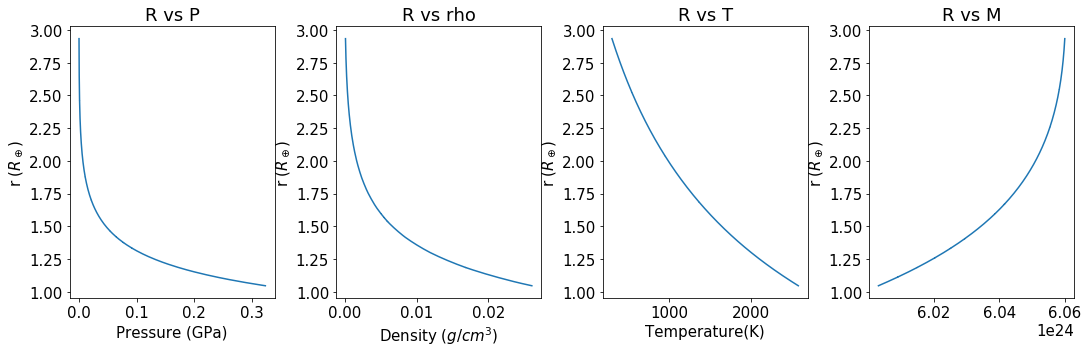

In [1064]:
# plot for the case that f=0, m_fct=1
fig, axes = plt.subplots(1, 4, figsize=(18,5))
plt.subplots_adjust(wspace=0.3)


Rs = np.array(planet.Env.r)
Ps = np.array(planet.Env.P)
rhos = np.array(planet.Env.rho)
Ts = np.array(planet.Env.T)
Ms = np.array(planet.Env.M)

# Rs = np.array(planet.Mantle.r)
# Ps = np.array(planet.Mantle.P)
# rhos = np.array(planet.Mantle.rho)
# Ts = np.array(planet.Mantle.T)
# Ms = np.array(planet.Mantle.M)

# Rs = np.array(planet.Env.r + planet.Mantle.r + planet.Metal.r)
# Ps = np.array(planet.Env.P + planet.Mantle.P + planet.Metal.P)
# rhos = np.array(planet.Env.rho + planet.Mantle.rho + planet.Metal.rho)
# metal_temperature = [planet.Mantle.T[-1]] * len(planet.Metal.r)
# Ts = np.array(planet.Env.T + planet.Mantle.T + metal_temperature)
# Ms = np.array(planet.Env.M + planet.Mantle.M + planet.Metal.M)

# R vs P
Rs /= 6371000
Ps /= 1e9 # Pa => GPa
axes[0].plot(Ps, Rs)
axes[0].set_title("R vs P")
axes[0].set_xlabel("Pressure (GPa)")
axes[0].set_ylabel(r'r ($R_\oplus$)')
# axes[0].set_ylim(9, 10)
# axes[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs rho
axes[1].plot(rhos/1e3, Rs)
axes[1].set_title("R vs rho")
axes[1].set_xlabel(r"Density ($g/cm^3$)")
axes[1].set_ylabel(r'r ($R_\oplus$)')
# axes[1].set_ylim(9, 10)
# axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs T
axes[2].plot(Ts, Rs)
axes[2].set_title("R vs T")
axes[2].set_xlabel("Temperature(K)")
axes[2].set_ylabel(r'r ($R_\oplus$)')
# axes[2].set_ylim(.9, 1)
# axes[2].set_xlim(1, 1000)

# R vs M
axes[3].plot(Ms, Rs)
axes[3].set_title("R vs M")
# axes[3].set_xlabel("M")
axes[3].set_ylabel(r'r ($R_\oplus$)')


# atmosphere r
R_env = planet.Env.r[-1] / 6371000
R_mantle = planet.Mantle.r[-1] / 6371000
R_max = planet.Env.r[0] / 6371000


# axes[0].fill_between([Ps[0], Ps[-1]], [R_env, R_env], [R_max, R_max])

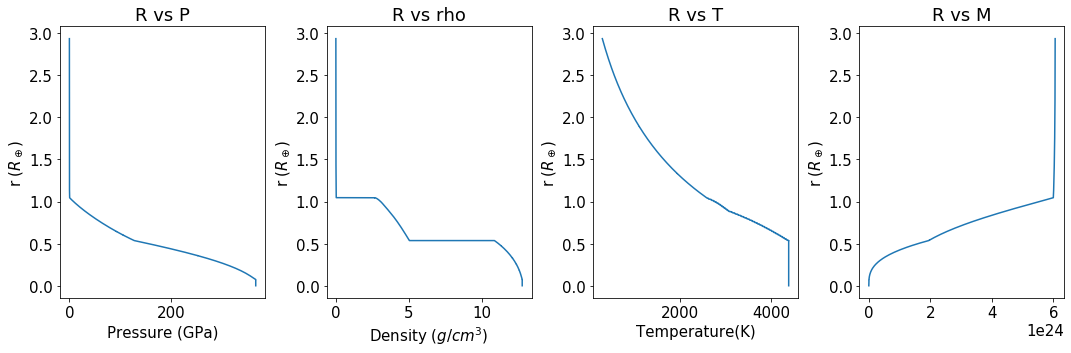

In [1065]:
# plot for the case that f=0, m_fct=1
fig, axes = plt.subplots(1, 4, figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

Rs = np.array(planet.Env.r + planet.Mantle.r + planet.Metal.r)
Ps = np.array(planet.Env.P + planet.Mantle.P + planet.Metal.P)
rhos = np.array(planet.Env.rho + planet.Mantle.rho + planet.Metal.rho)
metal_temperature = [planet.Mantle.T[-1]] * len(planet.Metal.r)
Ts = np.array(planet.Env.T + planet.Mantle.T + metal_temperature)
Ms = np.array(planet.Env.M + planet.Mantle.M + planet.Metal.M)

# R vs P
Rs /= 6371000
Ps /= 1e9 # Pa => GPa
axes[0].plot(Ps, Rs)
axes[0].set_title("R vs P")
axes[0].set_xlabel("Pressure (GPa)")
axes[0].set_ylabel(r'r ($R_\oplus$)')
# axes[0].set_ylim(9, 10)
# axes[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs rho
axes[1].plot(rhos/1e3, Rs)
axes[1].set_title("R vs rho")
axes[1].set_xlabel(r"Density ($g/cm^3$)")
axes[1].set_ylabel(r'r ($R_\oplus$)')
# axes[1].set_ylim(9, 10)
# axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs T
axes[2].plot(Ts, Rs)
axes[2].set_title("R vs T")
axes[2].set_xlabel("Temperature(K)")
axes[2].set_ylabel(r'r ($R_\oplus$)')
# axes[2].set_ylim(.9, 1)
# axes[2].set_xlim(1, 1000)

# R vs M
axes[3].plot(Ms, Rs)
axes[3].set_title("R vs M")
# axes[3].set_xlabel("M")
axes[3].set_ylabel(r'r ($R_\oplus$)')


# atmosphere r
R_env = planet.Env.r[-1] / 6371000
R_mantle = planet.Mantle.r[-1] / 6371000
R_max = planet.Env.r[0] / 6371000


# axes[0].fill_between([Ps[0], Ps[-1]], [R_env, R_env], [R_max, R_max])

# Solubility as a function of pressure and temperature


In [ ]:
def log10_linspace(start, stop, num):
    '''create a P array of shape (num,), in the interval [start, stop], with points distributed evenly on log10 scale'''
    log_start = np.log10(start)
    log_stop = np.log10(stop)
    log_array = np.linspace(log_start, log_stop, num)
    array = 10 ** log_array
    return array

In [14]:
def calc_fugacity_coeff(T_b, P_b, EOS_table, gas="H2"):
    ideal_gas_constant = 8.314 # unit in J/mol/K
    num_points = 500 # number of points for integration
    lower_pressure = 1e6   # lower bound for integration, unit in Pa (1e5 is also fine, but smaller than that lead to large error)
    
    if gas == "H2":
        mol_mass = 0.002 # unit in kg/mol
    elif gas == "He":
        mol_mass = 0.004 # unit in kg/mol
    
    P_array = log10_linspace(lower_pressure, P_b, num_points)
    rho_array = np.zeros_like(P_array)
    
    for (i, P) in enumerate(P_array):
        rho_array[i], out_of_table = interpolate_df(T_b, P, EOS_table, target="rho", col1="T", col2="P")
        if out_of_table:
            raise ValueError("(P, T) is out of table")
    
    # density if it's ideal gas        
    rho_ideal_array = P_array * mol_mass  / (ideal_gas_constant * T_b)
    # degree of compression
    z_array = rho_ideal_array / rho_array
    # (z-1) / p
    partition_function = (z_array - 1) / P_array
    # phi: fugacity coefficient
    ln_phi = np.sum(partition_function[:-1] * np.diff(P_array))
    phi = np.exp(ln_phi)
    
    return phi

In [209]:
def calc_fugacity_coeff(T_b, P_b, EOS_table, gas="H2"):
    ideal_gas_constant = 8.314 # unit in J/mol/K
    num_points = 5000 # number of points for integration
    lower_pressure = 1e6   # lower bound for integration, unit in Pa (1e5 is also fine, but smaller than that lead to large error)
    
    if gas == "H2":
        mol_mass = 0.002 # unit in kg/mol
    elif gas == "He":
        mol_mass = 0.004 # unit in kg/mol
    
    P_array = log10_linspace(lower_pressure, P_b, num_points)
    rho_array = np.zeros_like(P_array)
    
    for (i, P) in enumerate(P_array):
        rho_array[i], out_of_table = interpolate_df(T_b, P, EOS_table, target="rho", col1="T", col2="P")
        if out_of_table:
            raise ValueError("(P, T) is out of table")
    
    # density if it's ideal gas        
    rho_ideal_array = P_array * mol_mass  / (ideal_gas_constant * T_b)
    # degree of compression
    z_array = rho_ideal_array / rho_array
    # (z-1) / p
    partition_function = (z_array - 1) / P_array
    # phi: fugacity coefficient
    ln_phi = np.sum(partition_function[:-1] * np.diff(P_array))
    phi = np.exp(ln_phi)
    
    return phi

def calc_f(P_b, T_b, phi):
    '''calculate solubility (mass fraction), giving the partial pressure, temperature and fugacity coefficient'''
    T0 = 4000     # unit in K
    return 1e-11 * P_b * phi * np.exp(- T0 / T_b)
    
def calc_gas_solubility(P_b, T_b, EOS_H, EOS_He, gas, f_He_env=None):
    '''
    f: mass fraction of dissolved gas in the mantle
    f_He: mass fraction of helium for the dissolved gas
    f_He_env: mass fraction of helium in the envelope
    '''
    if gas == "H2":
        phi = calc_fugacity_coeff(T_b, P_b, EOS_H, gas)
        f = calc_f(P_b, T_b, phi)
        f_He = 0
        
    elif gas == "He":
        phi = calc_fugacity_coeff(T_b, P_b, EOS_He, gas)
        f = calc_f(P_b, T_b, phi)
        f_He = 1
        
    elif gas == "mix":
        if f_He_env is not None:
            P_He = P_b * f_He_env # partial pressure of He
            P_H2 = P_b * (1 - f_He_env) # partial pressure of H2
            phi_H2 = calc_fugacity_coeff(T_b, P_b, EOS_H, "H2")
            phi_He = calc_fugacity_coeff(T_b, P_b, EOS_He, "He")
            x_H2 = calc_f(P_H2, T_b, phi_H2)
            x_He = calc_f(P_He, T_b, phi_He)
            f = x_H2 + x_He
            f_He = x_He / f
        else:
            raise Exception("Please input mass fraction of helium in the envelope (0<f<1)")
        
    else:
        raise Exception("Please input a correct gas name (H2, He or mix)")
    
    return f, f_He

In [204]:
# Debug use only: test for pure He
T_b = 1500    # unit in K
P_b = 1e9     # unit in Pa
phi = calc_fugacity_coeff(T_b, P_b, EOS_He, gas="He") # 2.0752834939673606
f = calc_gas_solubility(P_b, phi, T_b)                # 0.0014419785942656627

points = []
for T_b in [3000, 2500, 1673]:
    for P_b in [1e9, 3e9, 7e9, 9e9, 10e9]:
#         phi = calc_fugacity_coeff(T_b, P_b, EOS_H, gas="H2")
        phi = calc_fugacity_coeff(T_b, P_b, EOS_He, gas="He")
        points.append((T_b, P_b, phi))
        print("T, P, phi: ", T_b, P_b, phi)
        
fig = plt.figure(figsize=(6, 4))

plt.plot([x[1] / 1e9 for x in points[:5]], np.log10([x[2] for x in points[:5]]), 'o-', color="blue", label="3000 K")
plt.plot([x[1] / 1e9 for x in points[5:10]], np.log10([x[2] for x in points[5:10]]), 'o-', color="purple", label="2500 K")
plt.plot([x[1] / 1e9 for x in points[10:15]], np.log10([x[2] for x in points[10:15]]), 'o-', color="red", label="1673 K")
plt.legend()
plt.xlabel('Pressure (GPa)')
plt.ylabel(r'$H_2$ fugacity coefficient ($\Phi_{He}$)')
plt.yticks(np.log10([x for x in range(1,10)]
                    +[10 * x for x in range(1,10)]
                    +[100 * x for x in range(1,10)] + [1000]),
            labels=[r'$10^0$','','','','','','','','',
                   r'$10^1$','','','','','','','','',
                   r'$10^2$','','','','','','','','',r'$10^3$'])
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.rcParams['font.size'] = '15'
plt.show()
fig.savefig("figures/He_solubility.png")


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


T, P, phi:  3000 1000000000.0 1.3295768531622751
T, P, phi:  3000 3000000000.0 2.25026753268436
T, P, phi:  3000 7000000000.0 5.372851420545378
T, P, phi:  3000 9000000000.0 7.900261878398205
T, P, phi:  3000 10000000000.0 9.498323945211618
T, P, phi:  2500 1000000000.0 1.4718521974384626
T, P, phi:  2500 3000000000.0 2.837595590975131
T, P, phi:  2500 7000000000.0 8.321009651796194
T, P, phi:  2500 9000000000.0 13.370219119819488
T, P, phi:  2500 10000000000.0 16.76205320022062
T, P, phi:  1673 1000000000.0 1.885446794049616
T, P, phi:  1673 3000000000.0 5.367984853299535
T, P, phi:  1673 7000000000.0 28.88877298998529
T, P, phi:  1673 9000000000.0 60.05202364344278
T, P, phi:  1673 10000000000.0 84.96123132384405


# Main funtion

In [49]:
# # read table for the first time
# EOS_H = read_table(os.path.join(data_folder, H_filename))
# EOS_He = read_table(os.path.join(data_folder, He_filename))
# EOS_HHe = read_table(os.path.join(data_folder, HHe_filename))
# NewEOS = read_EOS_Si(Si_filename)

# # save result to EOS_tables folder for future convenience
# EOS_H.to_csv("EOS_tables/EOS_H.csv")
# EOS_He.to_csv("EOS_tables/EOS_He.csv")
# EOS_HHe.to_csv("EOS_tables/EOS_HHe.csv")

In [50]:
# read table from folder
EOS_H = pd.read_csv("EOS_tables/EOS_H.csv")
EOS_He = pd.read_csv("EOS_tables/EOS_He.csv")
EOS_HHe = pd.read_csv("EOS_tables/EOS_HHe.csv")
NewEOS = read_EOS_Si(Si_filename)

In [13]:
# create result folder if it doesn't exist
figure_folder = "figures"
if not os.path.exists(figure_folder):
    os.mkdir(figure_folder)

In [14]:
# create result folder if it doesn't exist
result_folder = "results_fugacity_crisis"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [18]:
# # For the debug use, print the first 5 rows
# EOS_H.head(), EOS_He.head()

In [33]:
M_core=6e24 * 1
f=0           # mass fraction of dissolved gas
f_He=0        # mass fraction of Helium for the gas
f_M=0.325     # mass fraction of metal for the core

R_guess = 6371000 * 10 # initial guess for the radius (unit in m)
dr_coeff = 0.005       # precision of each step during the integration

T_EC=1600              # temperature at the core-envelope boundary (unit in K)
P_EC = 1e8             # pressure at the core-envelope boundary (unit in Pa)

# initialize value recorder
ValueRecorder = value_recorder()
MetalValueRecorder = value_recorder()
R_guess_history = guess_history()

R_guess_max = None
R_guess_min = None

# results: R_guess, ValueRecorder, MetalValueRecorder
R_guess_max = None 
R_guess_min = None 
results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
                    ValueRecorder, MetalValueRecorder, R_guess_history, R_guess_max, R_guess_min)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732


## Example 1: calculate the mass-radius relationship for Earth-like planets

In [37]:
# create result folder if it doesn't exist
result_folder = "results_f=0"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [45]:
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

for M_fct in fct:
    
    # save logging
    logging.info("The factor of M_Earth = {}".format(M_fct))
    print("\nThe factor of M_Earth = {}".format(M_fct))

    M_core=6e24 * M_fct
    f=0           # mass fraction of dissolved gas
    f_He=0        # mass fraction of Helium for the gas
    f_M=0.325     # mass fraction of metal for the core

    R_guess = 6371000 * 10 # initial guess for the radius (unit in m)
    dr_coeff = 0.005       # precision of each step during the integration

    T_EC=1600              # temperature at the core-envelope boundary (unit in K)
    P_EC = 1e8             # pressure at the core-envelope boundary (unit in Pa)

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()
    
    R_guess_max = None
    R_guess_min = None

    # results: R_guess, ValueRecorder, MetalValueRecorder
    R_guess_max = None 
    R_guess_min = None 
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
                        ValueRecorder, MetalValueRecorder, R_guess_history, R_guess_max, R_guess_min)
    
    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(M_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(M_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(M_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)




The factor of M_Earth = 1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732


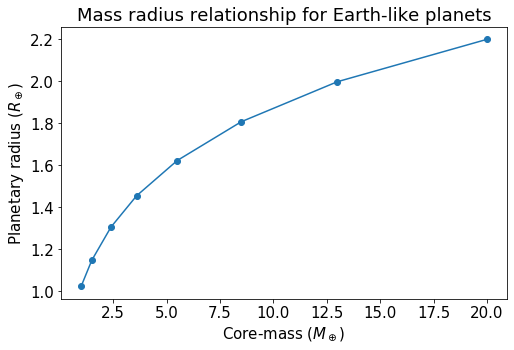

In [344]:
# read results
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]
final_Rs = []

for M_fct in fct:
    with open('results_f=0/R_guess_history_{}.pkl'.format(M_fct), 'rb') as file:
        R_guess_history = pickle.load(file)
    final_R = R_guess_history.r[-1]
    final_Rs.append(final_R)
    
final_Rs = np.array(final_Rs) / 6371000
    
fig = plt.figure(figsize=(8, 5))
plt.title('Mass radius relationship for Earth-like planets')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xlabel(r'Core-mass ($M_\oplus$)')
plt.plot(fct,final_Rs,'o-')
plt.show()
plt.rcParams['font.size'] = '16'
fig.savefig("figures/M_R_Earth.png")

### Check vertical thermal profiles for the $M_{core} = M_{Earth}$ case

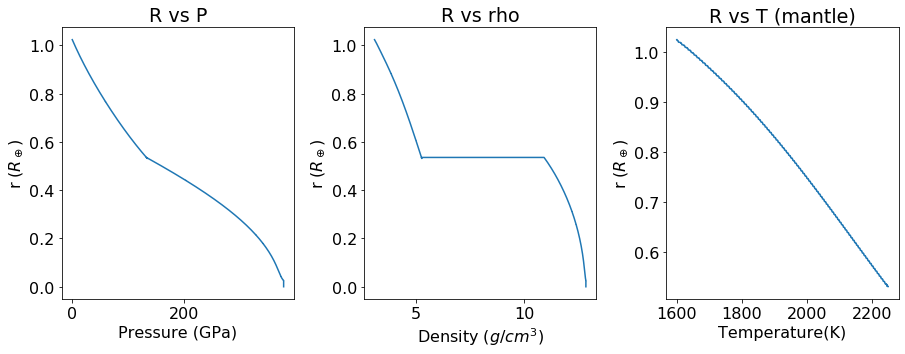

In [27]:
# plot for the case that f=0, m_fct=1
fig, axes = plt.subplots(1, 3, figsize=(15,5))
plt.subplots_adjust(wspace=0.3)

# read data
with open('results_f=0/ValueRecorder_1.pkl', 'rb') as file:
    ValueRecorder = pickle.load(file)
with open('results_f=0/MetalValueRecorder_1.pkl', 'rb') as file:
    MetalValueRecorder = pickle.load(file)

# R vs P
Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
Ps = np.array(ValueRecorder.P + MetalValueRecorder.P)
Rs /= 6371000
Ps /= 1e9 # Pa => GPa
axes[0].plot(Ps, Rs)
axes[0].set_title("R vs P")
axes[0].set_xlabel("Pressure (GPa)")
axes[0].set_ylabel(r'r ($R_\oplus$)')
# axes[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs rho
Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
rhos = np.array(ValueRecorder.rho + MetalValueRecorder.rho)
Rs /= 6371000
axes[1].plot(rhos/1e3, Rs)
axes[1].set_title("R vs rho")
axes[1].set_xlabel(r"Density ($g/cm^3$)")
axes[1].set_ylabel(r'r ($R_\oplus$)')
# axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs T
Rs = np.array(ValueRecorder.r)
Ts = np.array(ValueRecorder.T)
Rs /= 6371000
axes[2].plot(Ts, Rs)
axes[2].set_title("R vs T (mantle)")
axes[2].set_xlabel("Temperature(K)")
axes[2].set_ylabel(r'r ($R_\oplus$)')
# axes[2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

fig.savefig("Earth_R_P_rho_T.png")

## Sensitivity Test 1: For the Earth's parameters, start with $R_{guess} = 0.5 \times$, $1 \times$, $10 \times R_{Earth}$

Result: the result does not depend on the choice of $R_{guess}$

In [73]:
# create result folder if it doesn't exist
result_folder = "results_sensitivity"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [78]:
result_folder = "results_sensitivity"   
R_guess_fcts = [.5, 1, 10]

for R_guess_fct in R_guess_fcts:
    # save logging
    logging.info("The factor of R_guess = {}".format(R_guess_fct))
    print("\nThe factor of R_guess = {}".format(R_guess_fct))

    M_core=6e24
    f=0
    f_He=0
    f_M=0.325

    R_guess = 6371000 * R_guess_fct
    dr_coeff = 0.005

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()
    
    R_guess_max = None
    R_guess_min = None

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
                        ValueRecorder, MetalValueRecorder, R_guess_history, R_guess_max, R_guess_min)
    
    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(R_guess_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(R_guess_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(R_guess_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)



The factor of R_guess = 0.5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


new_R_guess: 31855000.0
new_R_guess: 10073435.486466372
new_R_guess: 5664709.060678989
new_R_guess: 7554010.939385203
new_R_guess: 6541503.971779238
new_R_guess: 6087340.701768339
new_R_guess: 6310337.818072105
new_R_guess: 6424881.314093468
new_R_guess: 6482930.40486728
new_R_guess: 6512151.333638347
new_R_guess: 6526811.151996258
new_R_guess: 6519477.12227584
new_R_guess: 6523143.106421507

The factor of R_guess = 1
new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732

The factor of R_guess = 10
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new

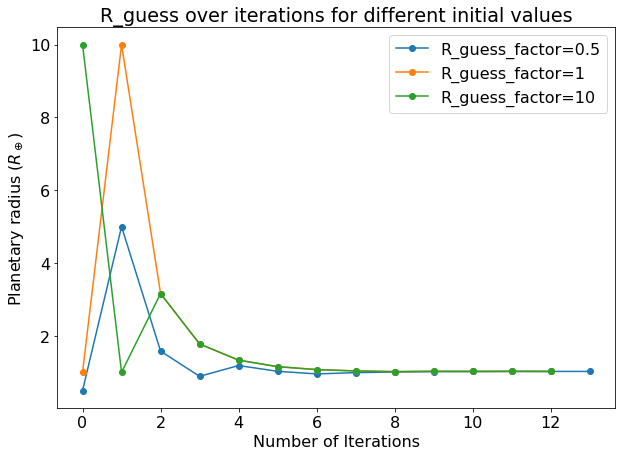

In [30]:
# read results
R_guess_fcts = [.5, 1, 10]
result_folder = "results_sensitivity"


fig = plt.figure(figsize=(10, 7))
for R_guess_fct in R_guess_fcts:
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(R_guess_fct)), 'rb') as file:
        R_guess_history = pickle.load(file)
    
    Rs = np.array(R_guess_history.r) / 6371000
    plt.plot(Rs, 'o-', label='R_guess_factor={}'.format(R_guess_fct))

plt.title('R_guess over iterations for different initial values')
plt.xlabel('Number of Iterations')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.legend()
plt.show()



## Sensitivity Test 2: Set the limit of max/min possble $R$, given the $R_{guess}$

Conclusion: $100 \times R_{guess}$ is okay as the starting max possible $R$ (min possible $R$ is $\frac{1}{100} \times R_{guess}$), compared to $10 \times R_{guess}$ and $5 \times R_{guess}$.

In [86]:
# create result folder if it doesn't exist
result_folder = "results_sensitivity_range"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [88]:
result_folder = "results_sensitivity_range"
R_guess_range_fcts = [5, 10, 100]    # the default is 100

for R_guess_range_fct in R_guess_range_fcts:
    # save logging
    logging.info("The factor of R_guess range = {}".format(R_guess_range_fct))
    print("\nThe factor of R_guess range = {}".format(R_guess_range_fct))

    M_core=6e24
    f=0
    f_He=0
    f_M=0.325

    R_guess = 6371000
    dr_coeff = 0.005

    T_EC=1600
    P_EC = 1e8
    
    R_guess_max = R_guess * R_guess_range_fct
    R_guess_min = R_guess / R_guess_range_fct

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
                        ValueRecorder, MetalValueRecorder, R_guess_history, R_guess_max, R_guess_min)
    
    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(R_guess_range_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(R_guess_range_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(R_guess_range_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)


The factor of R_guess range = 5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


new_R_guess: 14245989.084651161
new_R_guess: 9526867.085160397
new_R_guess: 7790742.596155831
new_R_guess: 7045198.441499629
new_R_guess: 6699623.81561787
new_R_guess: 6533246.002509124
new_R_guess: 6451612.998466789
new_R_guess: 6492301.1969539
new_R_guess: 6512741.42294044
new_R_guess: 6522985.655878848

The factor of R_guess range = 10
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732

The factor of R_guess range = 100
new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_g

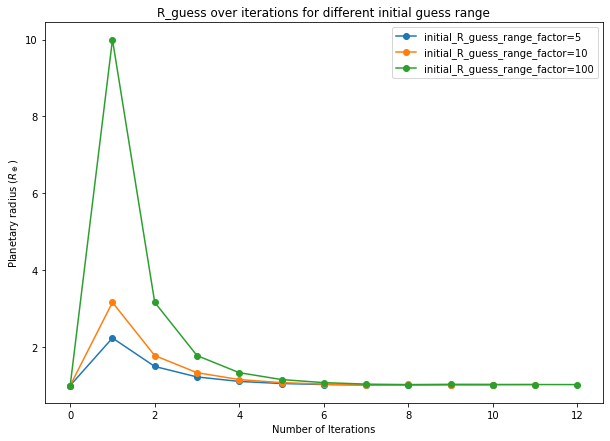

In [94]:
# read results
R_guess_range_fcts = [5, 10, 100]   
result_folder = "results_sensitivity_range"

fig = plt.figure(figsize=(10, 7))
for R_guess_range_fct in R_guess_range_fcts:
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(R_guess_range_fct)), 'rb') as file:
        R_guess_history = pickle.load(file)
    
    Rs = np.array(R_guess_history.r) / 6371000
    plt.plot(Rs, 'o-', label='initial_R_guess_range_factor={}'.format(R_guess_range_fct))

plt.title('R_guess over iterations for different initial guess range')
plt.xlabel('Number of Iterations')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.legend()
plt.show()

## Sensitivity test 3: Test the influence of changing precision (step size)

The precision is set by setting the max step size $dr_{max}$ for the RK4 integrator: $dr_{max}$ = $dr_{coeffs} \times R_{guess}$.

Conclusion: The final radius is not affected by the choice of precision. However, the errors of $P$ and $\rho$ in the lowest layers increase with the precision, producing a "long tail". The long tail is evident when $dr_{coeffs} \leq 0.1\%$. In the following part, we choose $dr_{coeffs} = 0.5\%$ for the default value.

In [38]:
# create result folder if it doesn't exist
result_folder = "results_sensitivity_drmax"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [39]:
result_folder = "results_sensitivity_drmax"
dr_coeffs = [0.001, 0.005, 0.01]    # the default is 0.005

for dr_coeff in dr_coeffs:
    # save logging
    logging.info("dr_coeff = {}".format(dr_coeff))
    print("\ndr_coeff = {}".format(dr_coeff))

    M_core=6e24
    f=0
    f_He=0
    f_M=0.325

    R_guess = 6371000
    dr_coeff = dr_coeff

    T_EC=1600
    P_EC = 1e8
    
    R_guess_max = None
    R_guess_min = None

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
                        ValueRecorder, MetalValueRecorder, R_guess_history, R_guess_max, R_guess_min)
    
    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(dr_coeff)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(dr_coeff)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(dr_coeff)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)


dr_coeff = 0.001


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732

dr_coeff = 0.005
new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732

dr_coeff = 0.01
new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 648664

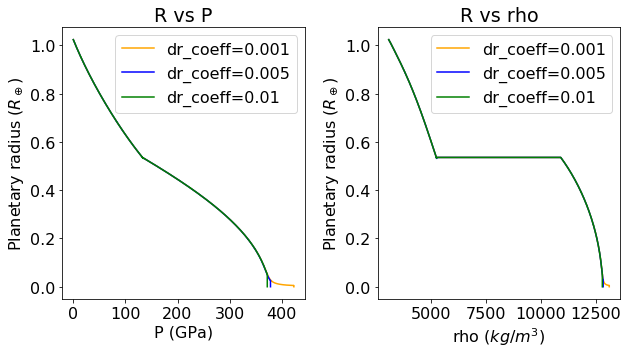

In [40]:
# read results
result_folder = "results_sensitivity_drmax"
dr_coeffs = [0.001, 0.005, 0.01]    # the default is 0.005
colors = ['orange', 'blue', 'green']

# make figures
fig, axes = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

axes[0].set_title("R vs P")
axes[0].set_xlabel("P (GPa)")
axes[0].set_ylabel(r'Planetary radius ($R_\oplus$)')

axes[1].set_title("R vs rho")
axes[1].set_xlabel(r"rho ($kg/m^3$)")
axes[1].set_ylabel(r'Planetary radius ($R_\oplus$)')

for (i, dr_coeff) in enumerate(dr_coeffs):
    color = colors[i]
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(dr_coeff)), 'rb') as file:
        ValueRecorder = pickle.load(file)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(dr_coeff)), 'rb') as file:
        MetalValueRecorder = pickle.load(file)
    
    # R vs P
    Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
    Ps = np.array(ValueRecorder.P + MetalValueRecorder.P)
    Rs /= 6371000
    Ps /= 1e9 # Pa => GPa
    axes[0].plot(Ps, Rs, color=color, label="dr_coeff={}".format(dr_coeff))
    
    # R vs rho
    Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
    rhos = np.array(ValueRecorder.rho + MetalValueRecorder.rho)
    Rs /= 6371000
    axes[1].plot(rhos, Rs, color=color, label="dr_coeff={}".format(dr_coeff))

axes[0].legend()
axes[1].legend()
plt.show()

## Sensitivity test 4: Test the depth ($r = r_{lim} \times dr_{max}$) where the integration stops in the metal core

Conclusion: The deeper the integration stops (the smaller $r_{lim}$), the larger error we get at lowest levels. Upper and middle levels are not influenced.  

In [95]:
# create result folder if it doesn't exist
result_folder = "results_sensitivity_rlim"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [103]:
# # This part is debug-use only
# r_lim = 10
# result_folder = "results_sensitivity_rlim"

# # save logging
# logging.info("Rlim = {}".format(r_lim))
# print("\nRlim = {}".format(r_lim))

# M_core=6e24
# f=0
# f_He=0
# f_M=0.325

# R_guess = 6371000
# dr_coeff = 0.005

# T_EC=1600
# P_EC = 1e8

# # initialize value recorder
# ValueRecorder = value_recorder()
# MetalValueRecorder = value_recorder()
# R_guess_history = guess_history()

# R_guess_max = None
# R_guess_min = None

# # results: R_guess, ValueRecorder, MetalValueRecorder
# results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
#                     ValueRecorder, MetalValueRecorder, R_guess_history)

# # save results
# with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(r_lim)), 'wb') as f:
#     pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(r_lim)), 'wb') as f:
#     pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(r_lim)), 'wb') as f:
#     pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

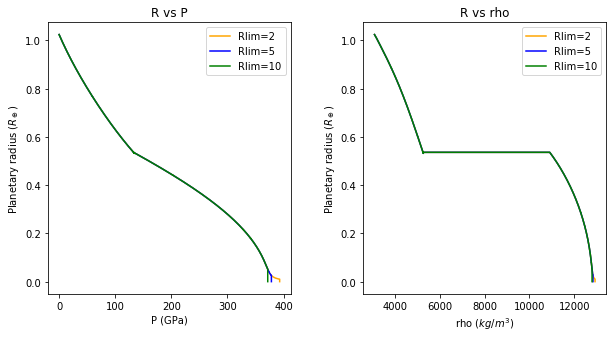

In [115]:
# read results
rlims = [2, 5, 10]   # the default is 5
colors = ['orange', 'blue', 'green']
result_folder = "results_sensitivity_rlim"

# make figures
fig, axes = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

axes[0].set_title("R vs P")
axes[0].set_xlabel("P (GPa)")
axes[0].set_ylabel(r'Planetary radius ($R_\oplus$)')

axes[1].set_title("R vs rho")
axes[1].set_xlabel(r"rho ($kg/m^3$)")
axes[1].set_ylabel(r'Planetary radius ($R_\oplus$)')

for (i, rlim) in enumerate(rlims):
    color = colors[i]
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(rlim)), 'rb') as file:
        ValueRecorder = pickle.load(file)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(rlim)), 'rb') as file:
        MetalValueRecorder = pickle.load(file)
    
    # R vs P
    Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
    Ps = np.array(ValueRecorder.P + MetalValueRecorder.P)
    Rs /= 6371000
    Ps /= 1e9 # Pa => GPa
    axes[0].plot(Ps, Rs, color=color, label="Rlim={}".format(rlim))
    
    # R vs rho
    Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
    rhos = np.array(ValueRecorder.rho + MetalValueRecorder.rho)
    Rs /= 6371000
    axes[1].plot(rhos, Rs, color=color, label="Rlim={}".format(rlim))

axes[0].legend()
axes[1].legend()
plt.show()

## Example 2: Mass-radius relationship with varied dissolved gas fraction

In [38]:
# cosmogenic composition
f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

# save results into a folder
result_folder = "results_fhe=0.275"

for f_value in f_values:
    
    # save logging
    logging.info("f = {}".format(f_value))

    M_core=6e24
    f=f_value
    f_He=0.275
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.001

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)
    
    # save results
    with open('results_fhe=0.275/ValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=0.275/MetalValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=0.275/R_guess_history_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [50]:
# pure Helium case
f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

# save results into a folder
f_He=0
result_folder = "results_fhe={}".format(f_He)

for f_value in f_values:
    
    # save logging
    logging.info("f = {}".format(f_value))

    M_core=6e24
    f=f_value
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.001

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)
    
    # save results
    with open('results_fhe=0/ValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=0/MetalValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=0/R_guess_history_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [51]:
# pure Hydrogen case
f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

# save results into a folder
f_He=1
result_folder = "results_fhe={}".format(f_He)

for f_value in f_values:
    
    # save logging
    logging.info("f = {}".format(f_value))

    M_core=6e24
    f=f_value
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.001

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)
    
    # save results
    with open('results_fhe=1/ValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=1/MetalValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=1/R_guess_history_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


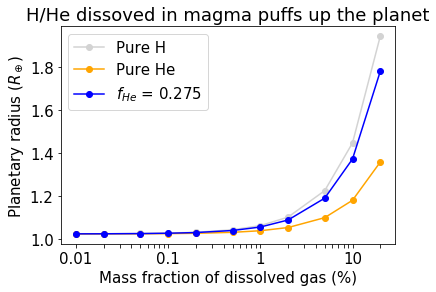

In [47]:
# plotting M-R relations with different dissolved gas compositions
# read results
f_values = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

x = np.log10(f_values)
y = []

for fhe in [0, 1, 0.275]:
    final_Rs = []
    for f_value in f_values:
        with open('results_fhe={}/R_guess_history_f={}.pkl'.format(fhe, f_value), 'rb') as file:
            R_guess_history = pickle.load(file)
        final_Rs.append(R_guess_history.r[-1] / 6371000)
    y.append(final_Rs)
        

# plot log10 because the x scale is uneven
# fig = plt.figure(figsize=(9, 4))
plt.plot(x, y[0], 'o-', color='lightgrey', label='Pure H')
plt.plot(x, y[1], 'o-', color='orange', label='Pure He')
plt.plot(x, y[2], 'o-', color='blue', label='$f_{He}$ = 0.275')
plt.legend()
plt.title('H/He dissoved in magma puffs up the planet')
plt.xlabel('Mass fraction of dissolved gas (%)')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xticks(np.log10([round(0.0001*x,4) for x in range(1,10)]
                    +[round(0.001*x,4) for x in range(1,10)]
                    +[round(0.01*x,4) for x in range(1,10)]+[0.1,0.2]),
           labels=['0.01','','','','','','','','',
                   '0.1','','','','','','','','',
                   '1','','','','','','','','','10',''])
plt.rcParams['font.size'] = '5'
plt.show()


## Example 3: Combining the effect of dissolved gas and planetary mass

In [48]:
# create result folder if it doesn't exist
result_folder = "results_combined_fM"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [80]:
from multiprocessing import Pool

def f(x):
    f_value, M_fct = x[0], x[1]
    # save logging
    logging.info("f = {}, M = {}".format(f_value, M_fct))
    print("f = {}, M = {}".format(f_value, M_fct))

    if os.path.exists(os.path.join(result_folder, 'ValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct))):
        return

    M_core=6e24 * M_fct
    f=f_value
    f_He=0.275
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.005

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)

    # save results

    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

if __name__ == '__main__':
    # cosmogenic composition
    f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
    fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

    # save results into a folder
    result_folder = "results_combined_fM"

    tups = []
    for f_value in f_values:
        for M_fct in fct:
            tups.append((f_value, M_fct))

    with Pool(5) as p:
        print(p.map(f, tups))
        

f = 0, M = 8.5
f = 0.0001, M = 20
f = 0, M = 1
f = 0.0001, M = 2.4
f = 0.0002, M = 5.5
f = 0.0002, M = 1
f = 0, M = 13
f = 0, M = 1.5
f = 0.0001, M = 3.6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


f = 0.0002, M = 1.5
f = 0, M = 20
f = 0, M = 2.4
f = 0.0001, M = 5.5
f = 0.0002, M = 2.4
f = 0.0001, M = 1
f = 0, M = 3.6
f = 0.0001, M = 8.5
f = 0.0001, M = 1.5
f = 0.0002, M = 3.6
f = 0, M = 5.5
f = 0.0001, M = 13
f = 0.0005, M = 1.5
f = 0.0005, M = 13
f = 0.001, M = 3.6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipyke

new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 15108021.878770405
new_R_guess: 9810871.897525024
new_R_guess: 9810871.897525024
new_R_guess: 13083007.943558477
new_R_guess: 9810871.897525024
new_R_guess: 9129723.08497969
new_R_guess: 9129723.08497969
new_R_guess: 7097127.462026886
new_R_guess: 12174681.403536677
new_R_guess: 9464171.57740775
new_R_guess: 10542839.743738009
new_R_guess: 9464171.57740775
new_R_g

new_R_guess: 11744447.884638444
new_R_guess: 14027524.71582011
new_R_guess: 7906014.4737492055
new_R_guess: 13562276.837304689
new_R_guess: 11535066.566325793
new_R_guess: 9326849.067895055
f = 0.0005, M = 1
new_R_guess: 6371000.0
new_R_guess: 8195634.936193464
f = 0.002, M = 8.5
new_R_guess: 13808455.512320386
new_R_guess: 9321607.410575246
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8344399.820859057
f = 0.002, M = 5.5
new_R_guess: 13933215.527065333
new_R_guess: 6371000.0
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 8419791.847415484
new_R_guess: 20146870.972932745
new_R_guess: 13996017.60468175
new_R_guess: 11329418.121357977
new_R_guess: 6846326.474235114
new_R_guess: 8382011.07033654
new_R_guess: 20146870.972932745
new_R_guess: 6604388.387076573
new_R_guess: 14027524.71582011
new_R_guess: 11329418.121357977
new_R_guess: 15108021.878770405
new_R_guess: 13083007.943558477
new_R_guess: 8363184.3022

new_R_guess: 6371000.0
new_R_guess: 8543759.43149933
new_R_guess: 13083007.943558477
new_R_guess: 6624839.765981426
new_R_guess: 12174681.403536677
f = 0.01, M = 3.6
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 11744447.884638444
f = 0.005, M = 1.5
new_R_guess: 20146870.972932745
new_R_guess: 6371000.0
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 11535066.566325793
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 20146870.972932745
new_R_guess: 11639286.410001628
new_R_guess: 8495865.044312537
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 15108021.878770405
new_R_guess: 9810871.897525024
f = 0.005, M = 13
new_R_guess: 7357116.024456538
new_R_guess: 6371000.0
new_R_guess: 13083007.943558477
new_R_guess: 9810871.897525024
new_R_guess: 7906014.4737492055
new_R_guess: 10542839.743738009
new_R_guess: 14059102.75413792
new_R_guess: 9129723.08497969
n

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


new_R_guess: 6371000.0
new_R_guess: 14059102.75413792
new_R_guess: 15108021.878770405
new_R_guess: 15108021.878770405
new_R_guess: 14059102.75413792
new_R_guess: 13562276.837304689
new_R_guess: 13083007.943558477
new_R_guess: 13083007.943558477
new_R_guess: 20146870.972932745
new_R_guess: 12174681.403536677
new_R_guess: 13562276.837304689
new_R_guess: 11329418.121357977
new_R_guess: 13808455.512320386
new_R_guess: 11744447.884638444
new_R_guess: 8495865.044312537
new_R_guess: 14059102.75413792
new_R_guess: 13320487.062986713
new_R_guess: 13933215.527065333
new_R_guess: 11535066.566325793
new_R_guess: 14574128.859228497
new_R_guess: 13201213.50698954
new_R_guess: 9810871.897525024
new_R_guess: 13996017.60468175
new_R_guess: 11431779.922111955
new_R_guess: 14314299.674938357
new_R_guess: 9129723.08497969
new_R_guess: 13260716.184866473
new_R_guess: 14027524.71582011
new_R_guess: 11483307.118297763
new_R_guess: 14443630.01437534
new_R_guess: 11509157.745514113
new_R_guess: 14043304.859110

new_R_guess: 12395672.8323812
new_R_guess: 19654654.66377777
f = 0.2, M = 13
new_R_guess: 12284680.19594797
new_R_guess: 6371000.0
new_R_guess: 19676764.998509392
new_R_guess: 12229557.12730445
new_R_guess: 20146870.972932745
new_R_guess: 19687829.491438754
new_R_guess: 12202088.416795008
new_R_guess: 11329418.121357977
new_R_guess: 12188377.206677863
new_R_guess: 15108021.878770405
new_R_guess: 12195230.884781651
new_R_guess: 12198659.168914218
new_R_guess: 17446471.489898246
new_R_guess: 12196944.906396337
new_R_guess: 18748114.839629333
new_R_guess: 18085586.831478026
new_R_guess: 18413871.37075303
new_R_guess: 18248990.91948432
new_R_guess: 18167105.159083206
new_R_guess: 18208002.006849248
new_R_guess: 18228484.94211585
new_R_guess: 18218240.59583874
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None,

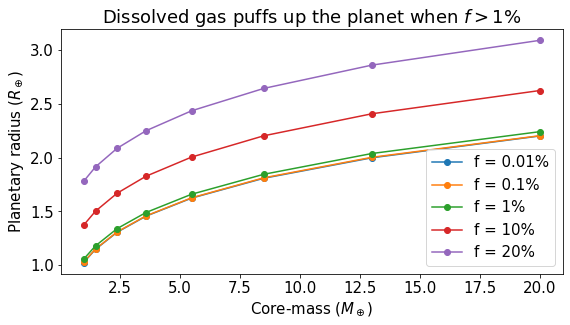

In [343]:
# plotting M-R relations with different dissolved gas compositions
# read results
f_values = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

x = np.log10(f_values)
y = []

result_folder = result_folder = "results_combined_fM"

final_Rs = []
f_display = [0.0001,0.001,0.01,0.1,0.2]

for f_value in f_display:
    R_forEachf = []
    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'rb') as f:
            R_guess_history = pickle.load(f)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs.append(R_forEachf)
        

x = fct
y = final_Rs

fig = plt.figure(figsize=(9, 4.5))
for (i, f_value) in enumerate(f_display):
    if f_value >= 0.01:
        plt.plot(x, y[i], 'o-', label='f = {:.0f}%'.format(f_value*100))
    else:
        plt.plot(x, y[i], 'o-', label='f = {}%'.format(f_value*100))
        
plt.legend(loc=4)
plt.title('Dissolved gas puffs up the planet when $f > 1 \%$')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xlabel(r'Core-mass ($M_\oplus$)')

plt.rcParams['font.size'] = '15'
plt.show()

## Example 4: Choosing the parameter for sub-Neptunes (P = 5GPa, T = 3000 K)

In [96]:
# create result folder if it doesn't exist
result_folder = "results_combined_fM_T=3000_P=5e9"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [97]:
from multiprocessing import Pool

def f(x):
    f_value, M_fct = x[0], x[1]
    # save logging
    logging.info("f = {}, M = {}".format(f_value, M_fct))
    print("f = {}, M = {}".format(f_value, M_fct))

    if os.path.exists(os.path.join(result_folder, 'ValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct))):
        return

    M_core=6e24 * M_fct
    f=f_value
    f_He=0.275
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.005

    T_EC=3000
    P_EC = 5e9

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)

    # save results

    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

if __name__ == '__main__':
    # cosmogenic composition
    f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
    fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

    # save results into a folder
    result_folder = "results_combined_fM_T=3000_P=5e9"

    tups = []
    for f_value in f_values:
        for M_fct in fct:
            tups.append((f_value, M_fct))

    with Pool(5) as p:
        print(p.map(f, tups))

f = 0.0001, M = 2.4
f = 0, M = 1
f = 0.0001, M = 20
f = 0, M = 8.5
f = 0.0002, M = 5.5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipyk

new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 7357116.024456538
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 6846326.474235114
new_R_guess: 8495865.044312537
new_R_guess: 15108021.878770405
new_R_guess: 7357116.024456538
new_R_guess: 6604388.387076573
new_R_guess: 13083007.943558477
new_R_guess: 15108021.878770405
new_R_guess: 6486644.619066536
new_R_guess: 12174681.403536677
new_R_guess: 9810871.897525024
new_R_guess: 13083007.943558477
new_R_guess: 7906014.4737492055
new_R_guess: 11744447.884638444
new_R_guess: 6545251.744070336
new_R_guess: 10542839.743738009

new_R_guess: 7626628.729288296
new_R_guess: 9384702.195197947
new_R_guess: 6846326.474235114
new_R_guess: 7490660.34718085
f = 0.0001, M = 13
new_R_guess: 10495532.555465953
new_R_guess: 6371000.0
f = 0.0005, M = 1.5
new_R_guess: 6371000.0
new_R_guess: 6604388.387076573
new_R_guess: 7423587.897641235
new_R_guess: 10471958.623686787
new_R_guess: 6724269.40719758
new_R_guess: 7390277.226241107
new_R_guess: 10460191.521193923
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 6664059.332304145
new_R_guess: 8495865.044312537
new_R_guess: 7406913.836203113
f = 0.0005, M = 13
new_R_guess: 6371000.0
new_R_guess: 7357116.024456538
new_R_guess: 6634156.77121507
new_R_guess: 7398590.855049496
new_R_guess: 15108021.878770405
new_R_guess: 7906014.4737492055
new_R_guess: 6619255.844719875
new_R_guess: 7402751.175925875
new_R_guess: 13083007.943558477
new_R_guess: 20146870.972932745
new_R_guess: 7626628.7292882

new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 20146870.972932745
new_R_guess: 12849762.628186936
new_R_guess: 8495865.044312537
new_R_guess: 11329418.121357977
new_R_guess: 7357116.024456538
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 12965860.80973456
new_R_guess: 20146870.972932745
new_R_guess: 8495865.044312537
new_R_guess: 6846326.474235114
new_R_guess: 15108021.878770405
new_R_guess: 11329418.121357977
new_R_guess: 13083007.943558477
new_R_guess: 12907681.188935554
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6604388.387076573
new_R_guess: 12174681.403536677
new_R_guess: 12878689.349391716
new_R_guess: 6724269.40719758
new_R_guess: 11744447.884638444
new_R_guess: 12893177.120217038
new_R_guess: 7906014.4737492055
new_R_guess: 9810871.897525024
new_R_guess: 6664059.332304145
new_R_guess: 11535066.566325793
new_R_guess: 12900427.116194244
new_R_guess: 6694096.675128191
new_R_guess: 10542839

new_R_guess: 13112459.734556785
new_R_guess: 9464171.57740775
new_R_guess: 13083007.943558477
new_R_guess: 8807093.460497178
new_R_guess: 13127210.483366445
new_R_guess: 12174681.403536677
new_R_guess: 9635962.586173981
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8650079.622352127
new_R_guess: 8495865.044312537
new_R_guess: 11744447.884638444
f = 0.01, M = 20
new_R_guess: 6371000.0
new_R_guess: 9723023.940230573
new_R_guess: 8572625.565954786
new_R_guess: 7357116.024456538
new_R_guess: 11957629.834374089
new_R_guess: 9766849.150784051
new_R_guess: 8611265.511997662
new_R_guess: 7906014.4737492055
new_R_guess: 11850559.497914193
new_R_guess: 20146870.972932745
new_R_guess: 9788835.776576977
new_R_guess: 11329418.121357977
new_R_guess: 8630650.747654816
new_R_guess: 7626628.729288296
new_R_guess: 11797384.38922206
new_R_guess: 9799847.643198675
new_R_guess: 8620952.681077467
new_R_guess: 7490660.34718085
new_R_guess: 11770886.378445152
f = 0.02, M = 5.5
n

new_R_guess: 16867828.143142942
new_R_guess: 11329418.121357977
new_R_guess: 13808455.512320386
new_R_guess: 12734704.006446136
new_R_guess: 19732149.71518957
new_R_guess: 8495865.044312537
new_R_guess: 16848874.147073533
new_R_guess: 13933215.527065333
new_R_guess: 12792103.956075951
new_R_guess: 19737696.753733497
f = 0.2, M = 1
new_R_guess: 6371000.0
new_R_guess: 9810871.897525024
new_R_guess: 13870695.251105955
new_R_guess: 12820900.879059436
new_R_guess: 12835323.641242046
new_R_guess: 13839540.39337471
new_R_guess: 20146870.972932745
new_R_guess: 10542839.743738009
new_R_guess: 11329418.121357977
new_R_guess: 12828110.233195398
new_R_guess: 13823989.215594595
new_R_guess: 8495865.044312537
new_R_guess: 10170272.86565848
f = 0.05, M = 13
new_R_guess: 6371000.0
new_R_guess: 13816220.180872
new_R_guess: 10354880.828513889
new_R_guess: 9810871.897525024
f = 0.2, M = 5.5
new_R_guess: 6371000.0
new_R_guess: 10448437.641127355
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357

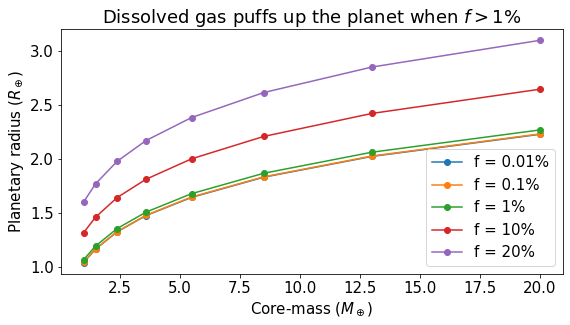

In [342]:
# plotting M-R relations with different dissolved gas compositions
# read results
f_values = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

x = np.log10(f_values)
y = []

result_folder = "results_combined_fM_T=3000_P=5e9"

final_Rs = []
f_display = [0.0001,0.001,0.01,0.1,0.2]

for f_value in f_display:
    R_forEachf = []
    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'rb') as f:
            R_guess_history = pickle.load(f)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs.append(R_forEachf)
        

x = fct
y = final_Rs

fig = plt.figure(figsize=(9, 4.5))
for (i, f_value) in enumerate(f_display):
    if f_value >= 0.01:
        plt.plot(x, y[i], 'o-', label='f = {:.0f}%'.format(f_value*100))
    else:
        plt.plot(x, y[i], 'o-', label='f = {}%'.format(f_value*100))
        
plt.legend(loc=4)
plt.title('Dissolved gas puffs up the planet when $f > 1 \%$')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xlabel(r'Core-mass ($M_\oplus$)')

plt.rcParams['font.size'] = '15'
plt.show()

In [101]:
result_folder = "results_combined_fM_T=3000_P=5e9"

final_Rs1 = []
for f_value in f_values:
    R_forEachf = []
    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'rb') as f:
            R_guess_history = pickle.load(f)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs1.append(R_forEachf)


In [102]:
result_folder = "results_combined_fM"

final_Rs2 = []
for f_value in f_values:
    R_forEachf = []
    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'rb') as f:
            R_guess_history = pickle.load(f)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs2.append(R_forEachf)


In [106]:
final_Rs1[0], final_Rs2[0]

([1.0363415954173512,
  1.1619449342216097,
  1.3223240311535487,
  1.4730344051480062,
  1.6418445332277387,
  1.8289718921910687,
  2.021454928487163,
  2.2266720103519186],
 [1.0244671730288477,
  1.1489542458604773,
  1.307540284613392,
  1.456565697949483,
  1.6244014159246445,
  1.8085237597770822,
  1.9988548118735106,
  2.2017775413310483])

The core-radius for ( P = 5GPa, T = 3000K ) is only 0.01~0.02 $R_\oplus$ larger compared to ( P = 0.5GPa, T = 1500 K ).

## Example 5: H2 and He solubility (fugacity) as a function of pressure and temperature

In [224]:
T_b_ls = [1500, 2000, 2500, 3000]         # list of temperature, unit in K
P_b_ls = [1e7, 2e9, 4e9, 6e9, 8e9, 10e9]  # list of pressure, unit in Pa

H2_points = []
for T_b in T_b_ls:
    for P_b in P_b_ls:
        phi = calc_fugacity_coeff(T_b, P_b, EOS_H, gas="H2")
        H2_points.append((T_b, P_b, phi))
        print("(H2) T, P, phi: ", T_b, P_b, phi)

He_points = []
for T_b in T_b_ls:
    for P_b in P_b_ls:
        phi = calc_fugacity_coeff(T_b, P_b, EOS_He, gas="He")
        He_points.append((T_b, P_b, phi))
        print("(He) T, P, phi: ", T_b, P_b, phi)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


(H2) T, P, phi:  1500 10000000.0 0.9843385038532587
(H2) T, P, phi:  1500 2000000000.0 5.908855161915425
(H2) T, P, phi:  1500 4000000000.0 27.324546031205426
(H2) T, P, phi:  1500 6000000000.0 103.48888750218349
(H2) T, P, phi:  1500 8000000000.0 344.44183269086756
(H2) T, P, phi:  1500 10000000000.0 1045.2549129652762
(H2) T, P, phi:  2000 10000000.0 0.9886484369915776
(H2) T, P, phi:  2000 2000000000.0 3.557490897859675
(H2) T, P, phi:  2000 4000000000.0 11.06225203233081
(H2) T, P, phi:  2000 6000000000.0 29.895407673281746
(H2) T, P, phi:  2000 8000000000.0 73.45105553240262
(H2) T, P, phi:  2000 10000000000.0 168.3765722718625
(H2) T, P, phi:  2500 10000000.0 0.991446721914666
(H2) T, P, phi:  2500 2000000000.0 2.612689191465426
(H2) T, P, phi:  2500 4000000000.0 6.339892602647572
(H2) T, P, phi:  2500 6000000000.0 13.877090226228907
(H2) T, P, phi:  2500 8000000000.0 28.21882854179166
(H2) T, P, phi:  2500 10000000000.0 54.33099796048177
(H2) T, P, phi:  3000 10000000.0 1.014749

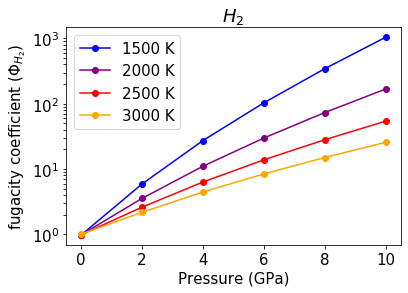

In [286]:
fig = plt.figure(figsize=(6, 4))
points = H2_points
ylabel = r'fugacity coefficient ($\Phi_{H_2}$)'
figname = "figures/H2_solubility.png"

plt.plot([x[1] / 1e9 for x in points[:6]], np.log10([x[2] for x in points[:6]]), 'o-', color="blue", label="1500 K")
plt.plot([x[1] / 1e9 for x in points[6:12]], np.log10([x[2] for x in points[6:12]]), 'o-', color="purple", label="2000 K")
plt.plot([x[1] / 1e9 for x in points[12:18]], np.log10([x[2] for x in points[12:18]]), 'o-', color="red", label="2500 K")
plt.plot([x[1] / 1e9 for x in points[18:24]], np.log10([x[2] for x in points[18:24]]), 'o-', color="orange", label="3000 K")
plt.legend()
plt.title(r'$H_2$')
plt.xlabel('Pressure (GPa)')
plt.ylabel(ylabel)
plt.yticks(np.log10([x for x in range(1,10)]
                    +[10 * x for x in range(1,10)]
                    +[100 * x for x in range(1,10)] + [1000]),
            labels=[r'$10^0$','','','','','','','','',
                   r'$10^1$','','','','','','','','',
                   r'$10^2$','','','','','','','','',r'$10^3$'])
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.rcParams['font.size'] = '15'
plt.show()
fig.savefig(figname)


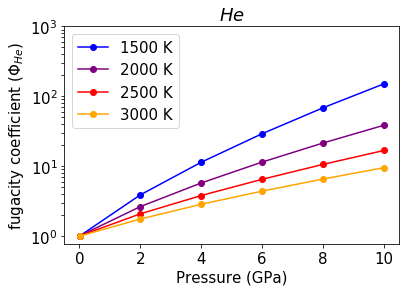

In [287]:
fig = plt.figure(figsize=(6, 4))
points = He_points
ylabel = r'fugacity coefficient ($\Phi_{He}$)'
figname = "figures/He_solubility.png"

plt.plot([x[1] / 1e9 for x in points[:6]], np.log10([x[2] for x in points[:6]]), 'o-', color="blue", label="1500 K")
plt.plot([x[1] / 1e9 for x in points[6:12]], np.log10([x[2] for x in points[6:12]]), 'o-', color="purple", label="2000 K")
plt.plot([x[1] / 1e9 for x in points[12:18]], np.log10([x[2] for x in points[12:18]]), 'o-', color="red", label="2500 K")
plt.plot([x[1] / 1e9 for x in points[18:24]], np.log10([x[2] for x in points[18:24]]), 'o-', color="orange", label="3000 K")
plt.legend()
plt.title(r'$He$')
plt.xlabel('Pressure (GPa)')
plt.ylabel(ylabel)
plt.yticks(np.log10([x for x in range(1,10)]
                    +[10 * x for x in range(1,10)]
                    +[100 * x for x in range(1,10)] + [1000]),
            labels=[r'$10^0$','','','','','','','','',
                   r'$10^1$','','','','','','','','',
                   r'$10^2$','','','','','','','','',r'$10^3$'])
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.rcParams['font.size'] = '15'
plt.show()
fig.savefig(figname)


# Example 6: Mass-radius relation when nonlinear solubility is included (pure H2 case and solar-gas-mixture case)

In [288]:
# create result folder if it doesn't exist
result_folder = "results_fugacity_crisis_T=3000_P=5e9"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [262]:
from multiprocessing import Pool

def g(x):
    f_He_env, M_fct, f, f_He = x[0], x[1], x[2], x[3]
    # save logging
    logging.info("f_He_env = {}, M = {}".format(f_He_env, M_fct))
    print("f_He_env = {}, M = {}".format(f_He_env, M_fct))

    if os.path.exists(os.path.join(result_folder, 'ValueRecorder_f_He_env={}_m={}.pkl'.format(f_He_env, M_fct))):
        return

    M_core=6e24 * M_fct
    f_M=0.325
    # f and f_He are the input
    R_guess = 6371000 * 10 
    dr_coeff = 0.005

    T_EC = 3000
    P_EC = 5e9

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)

    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_f_He_env={}_m={}.pkl'.format(f_He_env, M_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_f_He_env={}_m={}.pkl'.format(f_He_env, M_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_f_He_env={}_m={}.pkl'.format(f_He_env, M_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)


if __name__ == '__main__':
    f_He_env_values = [0, 0.25]                     # Helium mass fraction in the envelope
    fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]      # planet mass relative to the Earth
    T_b = 3000                                      # tempreature (K) at the envelope-core boundary
    P_b = 5e9                                       # pressure (Pa) at the envelope-core boundary 

    # save results into a folder
    result_folder = "results_fugacity_crisis_T=3000_P=5e9"

    tups = []
    for f_He_env in f_He_env_values:
        # calculate f, f_He
        if f_He_env == 0:
            f, f_He = calc_gas_solubility(P_b, T_b, EOS_H, EOS_He, gas="H2", f_He_env=None)
        else:
            f, f_He = calc_gas_solubility(P_b, T_b, EOS_H, EOS_He, gas="mix", f_He_env=f_He_env)

        for M_fct in fct:
            tups.append((f_He_env, M_fct, f, f_He))
    print("list of (envelope Helium fraction, mass, dissolved gas fraction, dissolved Helium fraction): "tups)
            
    with Pool(5) as p:
        p.map(g, tups)
        

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


6.18769539917498 3.5501764061368215 0.011697704255795527 0.06116470495328903
[(0, 1, 0.08155293993771871, 0), (0, 1.5, 0.08155293993771871, 0), (0, 2.4, 0.08155293993771871, 0), (0, 3.6, 0.08155293993771871, 0), (0, 5.5, 0.08155293993771871, 0), (0, 8.5, 0.08155293993771871, 0), (0, 13, 0.08155293993771871, 0), (0, 20, 0.08155293993771871, 0), (0.25, 1, 0.07286240920908456, 0.16054512035455787), (0.25, 1.5, 0.07286240920908456, 0.16054512035455787), (0.25, 2.4, 0.07286240920908456, 0.16054512035455787), (0.25, 3.6, 0.07286240920908456, 0.16054512035455787), (0.25, 5.5, 0.07286240920908456, 0.16054512035455787), (0.25, 8.5, 0.07286240920908456, 0.16054512035455787), (0.25, 13, 0.07286240920908456, 0.16054512035455787), (0.25, 20, 0.07286240920908456, 0.16054512035455787)]
f_He_env = 0, M = 1
f_He_env = 0, M = 1.5
f_He_env = 0, M = 3.6
f_He_env = 0, M = 2.4
f_He_env = 0, M = 5.5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipyk

new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 15108021.878770405
new_R_guess: 7357116.024456538
new_R_guess: 13083007.943558477
new_R_guess: 15108021.878770405
new_R_guess: 9810871.897525024
new_R_guess: 12174681.403536677
new_R_guess: 13083007.943558477
new_R_guess: 9810871.897525024
new_R_guess: 7906014.4737492055
new_R_guess: 9129723.08497969
new_R_guess: 11744447.884638444
new_R_guess: 12174681.403536677
new_R_guess: 10542839.743738009
new_R_guess: 11535066.566325793
new_R_guess: 9464171.57740775

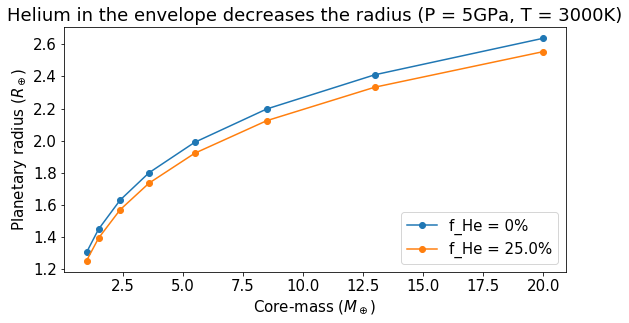

In [349]:
# plotting M-R relations with different dissolved gas compositions
# read results
f_He_env_values = [0, 0.25]
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

result_folder = "results_fugacity_crisis_T=3000_P=5e9"

final_Rs = []

for f_He_env in f_He_env_values:
    R_forEachf = []
    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f_He_env={}_m={}.pkl'.format(f_He_env, M_fct)), 'rb') as f:
            R_guess_history = pickle.load(f)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs.append(R_forEachf)
        

x = fct
y = final_Rs

fig = plt.figure(figsize=(9, 4.5))
for (i, f_He_env) in enumerate(f_He_env_values):
    plt.plot(x, y[i], 'o-', label=r'f_He = {}%'.format(f_He_env * 100))
        
plt.legend(loc=4)
plt.title('Helium in the envelope decreases the radius (P = 5GPa, T = 3000K)')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xlabel(r'Core-mass ($M_\oplus$)')

plt.rcParams['font.size'] = '15'
plt.show()

In [298]:
def calc_M_envelope(M_total, R, P_b):
    '''calculate the mass of envelope'''
    G = gravitational_constant
    g = 0.5 * G * M_total / R ** 2 # gravity constant
    A = 4 * np.pi * R ** 2
    M_envelope = P_b * A / g
    return M_envelope

def calc_M_dissolve(M_silicate, f):
    return f / (1 - f) * M_silicate

In [328]:
f_He_env_values = [0, 0.25]
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

result_folder = "results_fugacity_crisis_T=3000_P=5e9"

final_Rs = []
M_envelope_ls = []
M_dissolve_ls = []

for f_He_env in f_He_env_values:
    M_envelope_forEachf = []
    M_dissolve_forEachf = []
    
    T_b = 3000
    P_b = 5e9
    
    # calculate f, f_He
    if f_He_env == 0:
        f, f_He = calc_gas_solubility(P_b, T_b, EOS_H, EOS_He, gas="H2", f_He_env=None)
    else:
        f, f_He = calc_gas_solubility(P_b, T_b, EOS_H, EOS_He, gas="mix", f_He_env=f_He_env)

    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f_He_env={}_m={}.pkl'.format(f_He_env, M_fct)), 'rb') as file:
            R_guess_history = pickle.load(file)
        
        # get R
        R = R_guess_history.r[-1]
        M_core=6e24 * M_fct
        f_M = 0.325
        
        # calculate the total mass of each component
        M_silicate = (1-f_M) * M_core
        M_metal = f_M * M_core
        M_mantle = M_silicate / (1-f)
        M_total = M_mantle + M_metal
        
        # calculate the mass of gas
        M_envelope = calc_M_envelope(M_total, R, P_b)
        M_dissolve = calc_M_dissolve(M_silicate, f)
        
        M_envelope_forEachf.append(M_envelope)
        M_dissolve_forEachf.append(M_dissolve)
        
    M_envelope_ls.append(M_envelope_forEachf)
    M_dissolve_ls.append(M_dissolve_forEachf)

x_ex6 = fct
y1_ex6 = np.array(M_envelope_ls) / 6e24
y2_ex6 = np.array(M_dissolve_ls) / 6e24


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


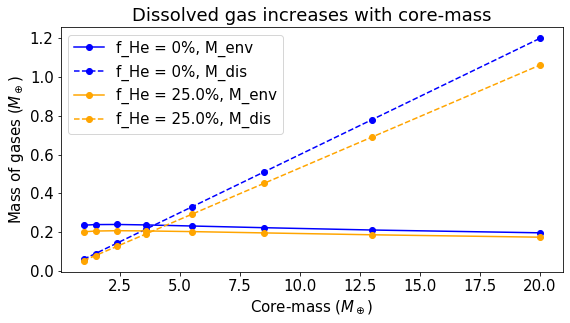

In [348]:
f_He_env_values = [0, 0.25]

fig = plt.figure(figsize=(9, 4.5))
for (i, f_He_env) in enumerate(f_He_env_values):
    if i == 0: 
        color = "blue" # for f_He_env = 0
    else:
        color = "orange" # for f_He_env = 0.25
    plt.plot(x_ex6, y1_ex6[i], '-o', label=r'f_He = {}%, M_env'.format(f_He_env * 100), color=color)
    plt.plot(x_ex6, y2_ex6[i], '--o', label=r'f_He = {}%, M_dis'.format(f_He_env * 100), color=color)

plt.legend(loc=0)
plt.title('Dissolved gas increases with core-mass')
plt.ylabel(r'Mass of gases ($M_\oplus$)')
plt.xlabel(r'Core-mass ($M_\oplus$)')

plt.rcParams['font.size'] = '15'
plt.show()

Explanation: 

1. $M_{env} = \frac{pA}{g}$, where 
\begin{equation}
    A = 4 \pi R^2 \\
    g = \frac{GM}{2R^2} \\
    M = M_{mantle}+M_{metal} = \frac{M_{silicate}}{1-f_{G}} + M_{core} \times f_{metal} = \frac{M_{core} \times (1-f_{metal})}{1-f_G} + M_{core} \times f_{metal}
\end{equation}
So
\begin{equation}
    M_{env} = \frac{8 \pi p R^4}{GM_{core}[f_{metal}+\frac{1-f_{metal}}{1-f_G}]}
\end{equation}
Here, everything is constant except for $R$ and $M_{core}$, $R^4$ increases with $M_{core}$ at the rate that their effects basically cancel out.  In the next cell I show $R^4 / M_{core}$. The relative change of its size is small.

2. $M_{dis} = f_G M_{mantle}$, where
\begin{equation}
    M_{mantle} = \frac{M_{silicate}}{(1-f_G)}\\
    M_{silicate} = (1-f_{metal})M_{core}
\end{equation}
So
\begin{equation}
    M_{dis} = \frac{f_G(1-f_{metal})}{1-f_G}M_{core}
\end{equation}
Every thing is consant except for $M_{core}$. $M_{dis}$ increase linearly with $M_{core}$, and the slope is controlled by $f_G$, which is further controlled by the pressure $P$ and the temperature $T$ at the envelope-magma boundary.

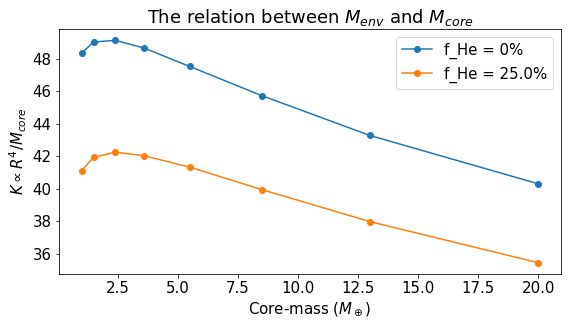

In [360]:
# y: R^4 / M_core, x: M_core

f_He_env_values = [0, 0.25]
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

result_folder = "results_fugacity_crisis_T=3000_P=5e9"

M_core_array = np.array(fct) * 6e4
x = np.array(fct)
y = np.array(final_Rs)
y = y ** 4 / M_core_array * 1e6

fig = plt.figure(figsize=(9, 4.5))
for (i, f_He_env) in enumerate(f_He_env_values):
    plt.plot(x, y[i], 'o-', label=r'f_He = {}%'.format(f_He_env * 100))
        
plt.legend(loc=1)
plt.title(r'The relation between $M_{env}$ and $M_{core}$')
plt.ylabel(r'$K \propto R^4 / M_{core}$')
plt.xlabel(r'Core-mass ($M_\oplus$)')

plt.rcParams['font.size'] = '15'
plt.show()

# Example 7: Nonlinear solubility leads to dramatic difference in planetary radii

In [278]:
# create result folder if it doesn't exist
result_folder = "results_fugacity_crisis_f_He_env=0.25"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [282]:
from multiprocessing import Pool

def g(x):
    T, P, f, f_He, M_fct = x[0], x[1], x[2], x[3], x[4]
    # save logging
    logging.info("T = {}, P = {}, M = {}, f={}, f_He={}".format(T, P, M_fct, f, f_He))
    print("T = {}, P = {}, M = {}, f={}, f_He={}".format(T, P, M_fct, f, f_He))

    if os.path.exists(os.path.join(result_folder, 'ValueRecorder_T={}_P={}.pkl'.format(T, P))):
        return

    M_core=6e24 * M_fct
    f_M=0.325
    # f and f_He are the input
    R_guess = 6371000 * 10 
    dr_coeff = 0.005

    T_EC = T
    P_EC = P

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)

    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_T={}_P={}_m={}.pkl'.format(T, P, M_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_T={}_P={}_m={}.pkl'.format(T, P, M_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_T={}_P={}_m={}.pkl'.format(T, P, M_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

if __name__ == '__main__':
    # cosmogenic composition
    f_He_env = 0.25
    TP_ls = [(1500, 5e8)]
    fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

    # save results into a folder
    result_folder = "results_fugacity_crisis_f_He_env=0.25"

    tups = []
    for (T, P) in TP_ls:
        f, f_He = calc_gas_solubility(P, T, EOS_H, EOS_He, gas="mix", f_He_env=f_He_env)
        for M_fct in fct:
            tups.append((T, P, f, f_He, M_fct))

    with Pool(5) as p:
        p.map(g, tups)
        

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


T = 1500, P = 500000000.0, M = 1, f=0.0005280803795509111, f_He=0.2400424235484998
T = 1500, P = 500000000.0, M = 1.5, f=0.0005280803795509111, f_He=0.2400424235484998
T = 1500, P = 500000000.0, M = 2.4, f=0.0005280803795509111, f_He=0.2400424235484998
T = 1500, P = 500000000.0, M = 3.6, f=0.0005280803795509111, f_He=0.2400424235484998


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


T = 1500, P = 500000000.0, M = 5.5, f=0.0005280803795509111, f_He=0.2400424235484998


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykern

new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 6846326.474235114
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6604388.387076573
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 9810871.897525024
new_R_guess: 6486644.619066536
new_R_guess: 9810871.897525024
new_R_guess: 9129723.08497969
new_R_guess: 7097127.462026886
new_R_guess: 6545251.744070336
new_R_guess: 7906014.4737492055
new_R_g

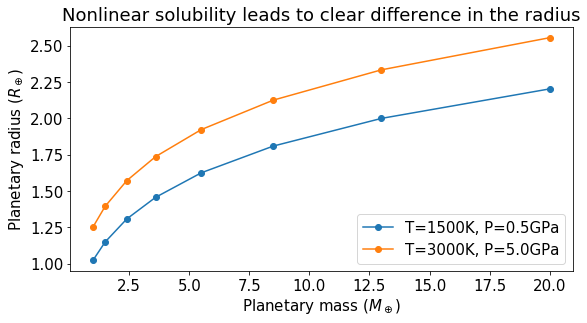

In [297]:
# fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]
# TP_ls = [(1500, 5e8)]

# result_folder = "results_fugacity_crisis_f_He_env=0.25"

# final_Rs = []
# for (T, P) in TP_ls:
#     R_forEachf = []
#     for M_fct in fct:
#         with open(os.path.join(result_folder, 'R_guess_history_T={}_P={}_m={}.pkl'.format(T, P, M_fct)), 'rb') as f:
#             R_guess_history = pickle.load(f)
#         R_forEachf.append(R_guess_history.r[-1] / 6371000)
#     final_Rs.append(R_forEachf)

    
# # steal T=3000, P=5GPa case from other folder
# result_folder = "results_fugacity_crisis_T=3000_P=5e9"
# for (T, P) in [(3000, 5e9)]:
#     R_forEachf = []
#     for M_fct in fct:
#         with open(os.path.join(result_folder, 'R_guess_history_f_He_env=0.25_m={}.pkl'.format(M_fct)), 'rb') as f:
#             R_guess_history = pickle.load(f)
#         R_forEachf.append(R_guess_history.r[-1] / 6371000)
#     final_Rs.append(R_forEachf)

fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]
TP_ls = [(1500, 5e8), (3000, 5e9)]

final_Rs = []
for (T, P) in TP_ls:
    
    R_forEachf = []
    for M_fct in fct:
        if T == 1500:
            result_folder = "results_fugacity_crisis_f_He_env=0.25"
            filename = 'R_guess_history_T={}_P={}_m={}.pkl'.format(T, P, M_fct)
        elif T == 3000:
            result_folder = "results_fugacity_crisis_T=3000_P=5e9"
            filename = 'R_guess_history_f_He_env=0.25_m={}.pkl'.format(M_fct)
        else:
            raise

        with open(os.path.join(result_folder, filename), 'rb') as file:
            R_guess_history = pickle.load(file)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs.append(R_forEachf)


    
x = fct
y = final_Rs

fig = plt.figure(figsize=(9, 4.5))
for (i, (T, P)) in enumerate(TP_ls + [(3000, 5e9)]):
    plt.plot(x, y[i], 'o-', label='T={}K, P={}GPa'.format(T, P/1e9))
        
plt.legend(loc=4)
plt.title('Nonlinear solubility leads to clear difference in the radius')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xlabel(r'Planetary mass ($M_\oplus$)')

plt.rcParams['font.size'] = '15'
plt.show()

In [361]:
f_He_env_values = 0.25
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]
TP_ls = [(1500, 5e8), (3000, 5e9)]


M_envelope_ls = []
M_dissolve_ls = []
for (T, P) in TP_ls:
    T_b, P_b = T, P
    f, f_He = calc_gas_solubility(P_b, T_b, EOS_H, EOS_He, gas="mix", f_He_env=f_He_env)
    
    M_envelope_forEach = []
    M_dissolve_forEach = []
    
    for M_fct in fct:
        if T == 1500:
            result_folder = "results_fugacity_crisis_f_He_env=0.25"
            filename = 'R_guess_history_T={}_P={}_m={}.pkl'.format(T, P, M_fct)
        elif T == 3000:
            result_folder = "results_fugacity_crisis_T=3000_P=5e9"
            filename = 'R_guess_history_f_He_env=0.25_m={}.pkl'.format(M_fct)
        else:
            raise

        with open(os.path.join(result_folder, filename), 'rb') as file:
            R_guess_history = pickle.load(file)
        # get R
        R = R_guess_history.r[-1]
        M_core=6e24 * M_fct
        f_M = 0.325
        
        # calculate the total mass of each component
        M_silicate = (1-f_M) * M_core
        M_metal = f_M * M_core
        M_mantle = M_silicate / (1-f)
        M_total = M_mantle + M_metal
        
        # calculate the mass of gas
        M_envelope = calc_M_envelope(M_total, R, P_b)
        M_dissolve = calc_M_dissolve(M_silicate, f)
        
        M_envelope_forEach.append(M_envelope)
        M_dissolve_forEach.append(M_dissolve)
        
    M_envelope_ls.append(M_envelope_forEach)
    M_dissolve_ls.append(M_dissolve_forEach)

x_ex7 = fct
y1_ex7 = np.array(M_envelope_ls) / 6e24
y2_ex7 = np.array(M_dissolve_ls) / 6e24

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


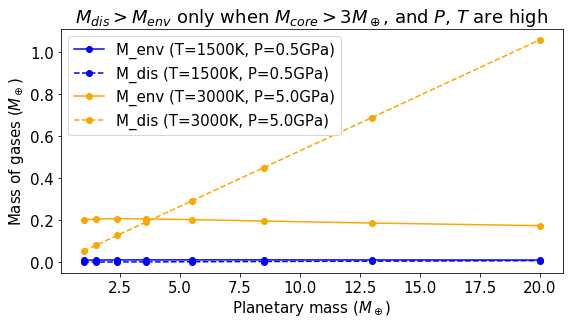

In [418]:

fig = plt.figure(figsize=(9, 4.5))
for (i, (T, P)) in enumerate(TP_ls):
    if i == 0:
        color = "blue"
    else:
        color = "orange"
    plt.plot(x_ex7, y1_ex7[i], '-o', label='M_env (T={}K, P={}GPa)'.format(T, P/1e9), color=color)
    plt.plot(x_ex7, y2_ex7[i], '--o', label='M_dis (T={}K, P={}GPa)'.format(T, P/1e9), color=color)
        
plt.legend(loc=0)
plt.title(r'$M_{dis}>M_{env}$ only when $M_{core}> 3M_\oplus$, and $P$, $T$ are high')
plt.ylabel(r'Mass of gases ($M_\oplus$)')
plt.xlabel(r'Planetary mass ($M_\oplus$)')

plt.rcParams['font.size'] = '15'
plt.show()

Explanation: 

Again, $M_{env}$ does not strongly depend on $M_{core}$. Here we focus on explain $M_{dis}$, and the difference between (T = 3000K, P = 5 GPa) and (T = 1500 K, P = 0.5 GPa). The slope of $M_{dis}$ vs $M_{core}$ is proportional to $K' = \frac{f_G}{1-f_G}$. For the high pressure, high temperature case, $f_G = 7\%$, $K' = 0.07526882$. For the low pressure, low temperature case, $f_G = 0.05\%$ ,$K' = 0.00050025$, so the slope is $150 \sim 10^2$ larger for the high pressure case compared to the low pressure case.

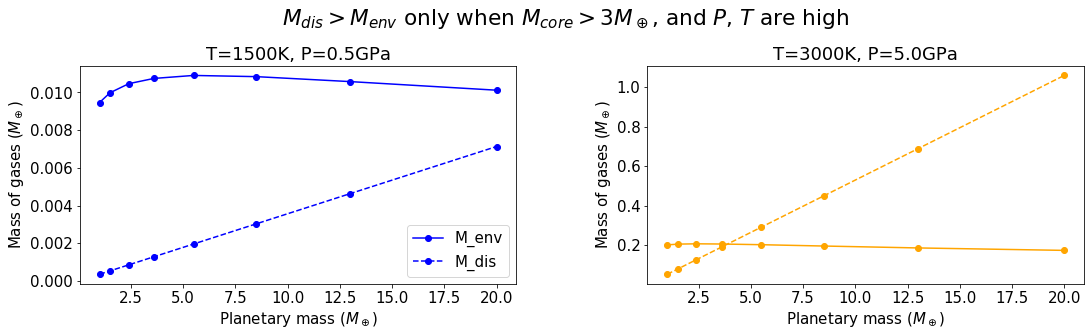

In [416]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4.5))
fig.suptitle(r'$M_{dis}>M_{env}$ only when $M_{core}> 3M_\oplus$, and $P$, $T$ are high', fontsize="x-large")

for (i, (T, P)) in enumerate(TP_ls):
    if i == 0:
        color = "blue"
    else:
        color = "orange"
    ax[i].plot(x_ex7, y1_ex7[i], '-o', label='M_env', color=color)
    ax[i].plot(x_ex7, y2_ex7[i], '--o', label='M_dis', color=color)
    
    ax[i].set_ylabel(r'Mass of gases ($M_\oplus$)')
    ax[i].set_xlabel(r'Planetary mass ($M_\oplus$)')
    ax[i].set_title('T={}K, P={}GPa'.format(T, P/1e9))
    
    if i == 0:
        ax[i].legend(loc=4)
    

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(top=0.8)

# fig.legend(bbox_to_anchor=(1, 1), loc="upper left")



In [315]:
def calc_atmos(R_c, T_eq, T_b, P_b, M_c):
    '''calculate the structure of the atmosphere
    input:
        R_c: radius of the core
        T_eq: equilibrium temperature at the radiative-convective boundary
        T_b: temperature at the atmosphere-core boundary
        P_b: pressure at the atmosphere-core boundary
        M_c: core mass
        f: mass fraction of H2
    '''
    # calculate the radius of R_rcb
    G = gravitational_constant
    k = Boltzmann
    gamma = 7 / 5
    m_H = 1.00784 * 1.66 * 1e-27
    mu = 1/2 # to be changed later
    c_s = (k * T_eq / mu / m_H)**(1/2)  # sound speed

    lambda_ad = (gamma - 1) / gamma # adiabatic lapse rate
    ideal_gas_constant = 8.314 # unit in J/mol/K
    mol_mass_H = 0.002 # unit in kg/mol
    
    # radius of radiative-convective boundary
    R_rcb = 1 / (1/R_c + (c_s ** 2 * (np.log(T_eq) - np.log(T_b)) / lambda_ad / G / M_c))
    
    #
    R_array = np.linspace(R_c, R_rcb, num=100)
    T_array = T_b * np.exp(lambda_ad * G * M_c / c_s ** 2 * (1/R_array - 1/R_c))
    P_array = P_b * np.exp(G * M_c / c_s ** 2 * (1/R_array - 1/R_c))
    rho_array = P_array / (ideal_gas_constant / mol_mass_H) / T_array
    
    # photospheric radius
    g = G * M_c / R_rcb ** 2 # gravity at rcb
    scale_height = k * T_eq / mu / m_H / g
    # method 1
    R_p1 = R_rcb + 6 * scale_height
    # method 2
    rho_rcb = rho_array[-1]
    
    alpha = .68
    beta = .45
    c = -7.32
    kappa = 10 ** c * rho_rcb ** alpha * (k / mu / m_H) ** alpha * T_eq ** (alpha + beta)
    rho_ph = 2 / 3 / scale_height / kappa
    R_p2 = R_rcb + np.log(rho_rcb / rho_ph) * scale_height
    
    return R_rcb, R_p1, R_p2, [R_array, T_array, P_array, rho_array]
    

In [316]:
M_fct = 5.5
f_M = 0.325
earth_radius = 6371000
earth_mass = 6e24
M_core= earth_mass * M_fct
T_b = 3000
P_b = 5e9
T_eq = 1200
f = 0.08155293993771871
    
result_folder = "results_fugacity_crisis_T=3000_P=5e9"
filename = "ValueRecorder_f_He_env=0_m={}.pkl".format(M_fct)
with open(os.path.join(result_folder, filename), 'rb') as file:
    Value_recorder = pickle.load(file)
    R_c = Value_recorder.r[0]
    
    # calculate the total mass of each component
    
    M_silicate = (1-f_M) * M_core
    M_metal = f_M * M_core
    M_mantle = M_silicate / (1-f)
    M_total = M_mantle + M_metal
    
    print("R_c, T_eq, T_b, P_b, M_c: ", R_c, T_eq, T_b, P_b, M_total)
    results = calc_atmos(R_c, T_eq, T_b, P_b, M_c=M_total)
    

R_c, T_eq, T_b, P_b, M_c:  12677561.618373733 1200 3000 5000000000.0 3.4977894879416894e+25


In [317]:
R_rcb, R_p1, R_p2, [R_array, T_array, P_array, rho_array] = results
R_p1/earth_radius

6.030192490990863

Text(0, 0.5, 'r ($R_\\oplus$)')

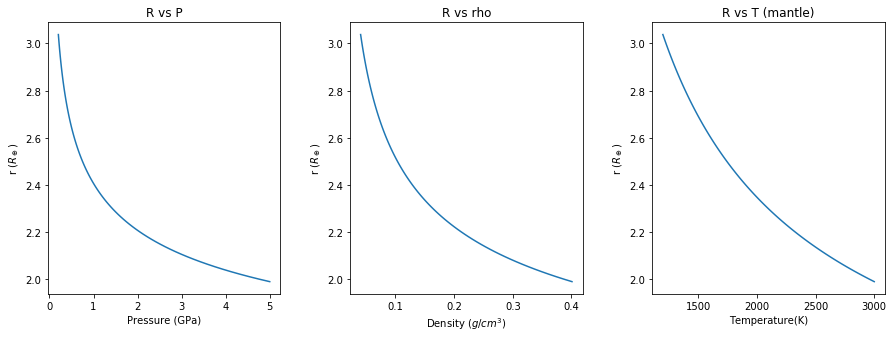

In [318]:
# plot for the case that f=0, m_fct=1
fig, axes = plt.subplots(1, 3, figsize=(15,5))
plt.subplots_adjust(wspace=0.3)

# R vs P
Rs = R_array
Ps = P_array
Rs /= 6371000
Ps /= 1e9 # Pa => GPa
axes[0].plot(Ps, Rs)
axes[0].set_title("R vs P")
axes[0].set_xlabel("Pressure (GPa)")
axes[0].set_ylabel(r'r ($R_\oplus$)')
# axes[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs rho
rhos = rho_array
axes[1].plot(rhos/1e3, Rs)
axes[1].set_title("R vs rho")
axes[1].set_xlabel(r"Density ($g/cm^3$)")
axes[1].set_ylabel(r'r ($R_\oplus$)')
# axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs T
Ts = T_array
axes[2].plot(Ts, Rs)
axes[2].set_title("R vs T (mantle)")
axes[2].set_xlabel("Temperature(K)")
axes[2].set_ylabel(r'r ($R_\oplus$)')
# axes[2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

In [319]:
# calculate the radius of R_rcb
M_c = M_total
G = gravitational_constant
k = Boltzmann # unit in J/K
gamma = 7 / 5
m_H = 1.00784 * 1.66 * 1e-27
mu = 1/2 # to be changed later
c_s = (k * T_eq / mu / m_H)**(1/2)  # sound speed

lambda_ad = (gamma - 1) / gamma # adiabatic lapse rate
ideal_gas_constant = 8.314 # unit in J/mol/K
mol_mass_H = 0.002 # unit in kg/mol

# radius of radiative-convective boundary
R_rcb = 1 / (1/R_c + (c_s ** 2 * (np.log(T_eq) - np.log(T_b)) / lambda_ad / G / M_c))

In [320]:
#
R_array = np.linspace(R_c, R_rcb, num=100)
T_array = T_b * np.exp(lambda_ad * G * M_c / c_s ** 2 * (1/R_array - 1/R_c))
P_array = P_b * np.exp(G * M_c / c_s ** 2 * (1/R_array - 1/R_c))
rho_array = P_array / (ideal_gas_constant / mol_mass_H) / T_array

In [321]:
R_rcb/R_c, R_rcb

(1.526557288903022, 19353024.094045613)

In [322]:
lambda_ad

0.28571428571428564

In [323]:
# photospheric radius
g = G * M_c / R_rcb ** 2 # gravity at rcb
scale_height = k * T_eq / mu / m_H / g
# method 1
R_p1 = R_rcb + 6 * scale_height
# method 2
rho_rcb = rho_array[-1]

alpha = .68
beta = .45
c = -7.32
kappa = 10 ** c * rho_rcb ** alpha * (k / mu / m_H) ** alpha * T_eq ** (alpha + beta)
rho_ph = 2 / 3 / scale_height / kappa
R_p2 = R_rcb + np.log(rho_rcb / rho_ph) * scale_height


In [324]:
gamma = 7/5
T_ls = np.linspace(300, 3000, 11)
P_ls = 5e9 * (T_ls / 3000) ** (gamma / (gamma - 1))
rho_ls = np.zeros_like(T_ls)
grad_ad_ls = np.zeros_like(T_ls)

for (i, (T, P)) in enumerate(zip(T_ls, P_ls)):
    rho_ls[i], out_of_table = interpolate_df(T, P, EOS_H, "rho")
    if out_of_table: print("Out of table, T={}, P={}".format(T, P))
    grad_ad_ls[i], out_of_table = interpolate_df(T, P, EOS_H, "grad_ad")
    if out_of_table: print("Out of table, T={}, P={}".format(T, P))
        
molar_mass_H2 = 2e-3
molar_mass_H = 1e-3
ideal_gas_constant = 8.314
rho_prime_ls1 = P_ls * molar_mass_H2 / ideal_gas_constant / T_ls
rho_prime_ls2 = P_ls * molar_mass_H / ideal_gas_constant / T_ls

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


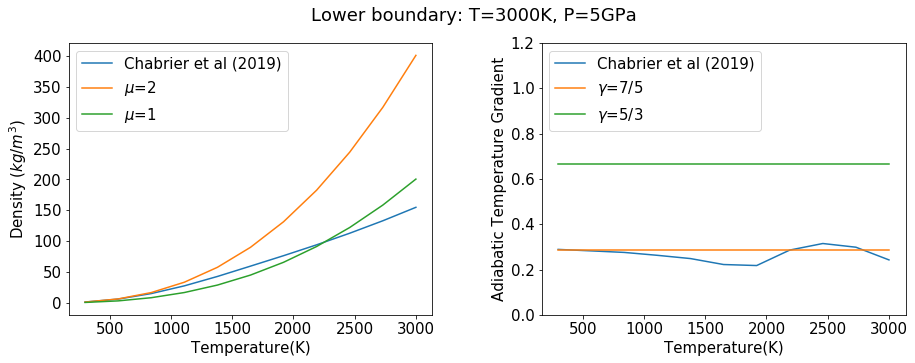

In [325]:
plt.rcParams['font.size'] = '15'
fig, axes = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle("Lower boundary: T=3000K, P=5GPa")

axes[0].plot(T_ls, rho_ls, label="Chabrier et al (2019)")
axes[0].plot(T_ls, rho_prime_ls1, label=r"$\mu$=2")
axes[0].plot(T_ls, rho_prime_ls2, label=r"$\mu$=1")
axes[0].set_xlabel("Temperature(K)")
axes[0].set_ylabel("Density ($kg/m^3$)")

axes[1].plot(T_ls, grad_ad_ls, label="Chabrier et al (2019)")
axes[1].plot([T_ls[0], T_ls[-1]], [2/7, 2/7], label=r"$\gamma$=7/5")
axes[1].plot([T_ls[0], T_ls[-1]], [2/3, 2/3], label=r"$\gamma$=5/3")
axes[1].set_xlabel("Temperature(K)")
axes[1].set_ylabel("Adiabatic Temperature Gradient")
axes[1].set_ylim(0, 1.2)

axes[0].legend(loc="upper left")
axes[1].legend(loc="upper left")
plt.subplots_adjust(wspace=0.3)
plt.show()

In [326]:
gamma = 7/5
T_ls = np.linspace(200, 400, 11)
P_ls = 2e5 * (T_ls / 400) ** (gamma / (gamma - 1))
rho_ls = np.zeros_like(T_ls)
grad_ad_ls = np.zeros_like(T_ls)

for (i, (T, P)) in enumerate(zip(T_ls, P_ls)):
    rho_ls[i], out_of_table = interpolate_df(T, P, EOS_H, "rho")
    if out_of_table: print("Out of table, T={}, P={}".format(T, P))
    grad_ad_ls[i], out_of_table = interpolate_df(T, P, EOS_H, "grad_ad")
    if out_of_table: print("Out of table, T={}, P={}".format(T, P))
        
molar_mass_H2 = 2e-3
ideal_gas_constant = 8.314
rho_prime_ls = P_ls * molar_mass_H2 / ideal_gas_constant / T_ls

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


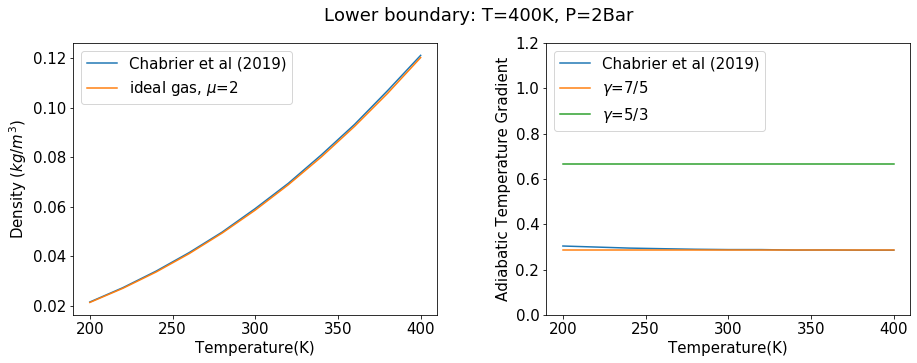

In [330]:
plt.rcParams['font.size'] = '15'
fig, axes = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle("Lower boundary: T=400K, P=2Bar")

axes[0].plot(T_ls, rho_ls, label="Chabrier et al (2019)")
axes[0].plot(T_ls, rho_prime_ls, label=r"ideal gas, $\mu$=2")
axes[0].set_xlabel("Temperature(K)")
axes[0].set_ylabel("Density ($kg/m^3$)")

axes[1].plot(T_ls, grad_ad_ls, label="Chabrier et al (2019)")
axes[1].plot([T_ls[0], T_ls[-1]], [2/7, 2/7], label=r"$\gamma$=7/5")
axes[1].plot([T_ls[0], T_ls[-1]], [2/3, 2/3], label=r"$\gamma$=5/3")
axes[1].set_xlabel("Temperature(K)")
axes[1].set_ylabel("Adiabatic Temperature Gradient")
axes[1].set_ylim(0, 1.2)

axes[0].legend(loc="upper left")
axes[1].legend(loc="upper left")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [344]:
T = 300
P = 1e5
interpolate_df(T, P, EOS_H, "grad_ad")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


(0.2880603576690328, False)

In [340]:
P_ls, T_ls

(array([ 17677.66952966,  24677.40046581,  33462.57611123,  44281.95068253,
         57394.87782024,  73070.89344431,  91589.34435839, 113239.0547967 ,
        138318.02485576, 167133.15602761, 200000.        ]),
 array([200., 220., 240., 260., 280., 300., 320., 340., 360., 380., 400.]))

### Test case 1.00 (old) in bodenheimer et al (2018)

In [54]:
M_core=6e24 * 7
# f=0           # mass fraction of dissolved gas
# f_He=0        # mass fraction of Helium for the gas
f_M=0.325     # mass fraction of metal for the core

R_guess = 1* 10 ** 7.375  # initial guess for the radius (unit in m)
dr_coeff = 0.005          # precision of each step during the integration

# T_EC=1600              # temperature at the core-envelope boundary (unit in K)
# P_EC = 1e8             # pressure at the core-envelope boundary (unit in Pa)

X = 0.68 / 7
X_He = 0.25
T_eff = 1e3
P_eff = 1e7

# # core only
# X = 0
# T_eff=6327.932230284772
# P_eff=242634728.90904266

# a point that couldnt converge
# R_guess = 591134836.7712742
# R_guess_max=591108875.6893101
# R_guess_min=591025807.8885337

new_planet = Planet(M_core, f_M, X, X_He)
new_planet.set_f_fHe(0, 0)
setattr(new_planet, "P_eff", P_eff)
setattr(new_planet, "T_eff", T_eff)

R_guess_history = guess_history()
R_guess_max = None
R_guess_min = None

R_guess = 24458382
R_guess_max=None
R_guess_min=None


results = integrate_with_atmos(new_planet, R_guess, dr_coeff, EOS, 
                               R_guess_history, R_guess_max, R_guess_min, fugacity=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


T_EC=6173.328632550312, P_EC=22204076829.75653


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


M_error / M_core: -0.0006841026894747166
P_EC, T_EC, f, f_He,  22204076829.75653 6173.328632550312 29.39535219114215 0.0056605490445923315
T_EC=5522.981201882922, P_EC=1905574634.3340816
M_error / M_core: -1.758971728162399
new_R_guess: 8826787.40318356
T_EC=20518.149020936307, P_EC=700076062277.1913
Break @ Mantle
new_R_guess: 14693159.56967226
T_EC=10995.411085311922, P_EC=24999735177.027966
Break @ Mantle
new_R_guess: 18957080.723096576
T_EC=7979.130889643991, P_EC=6650899610.351517
Break @ Mantle
new_R_guess: 21532754.629408944
T_EC=6622.322022583419, P_EC=3535206699.329034
M_error / M_core: -0.3104227352109163
new_R_guess: 20203914.662766147
T_EC=7266.737533052647, P_EC=4839099360.799381
M_error / M_core: 0.13507579756660698
new_R_guess: 20857754.840511024
T_EC=6935.892968946689, P_EC=4134053103.514119
M_error / M_core: -0.07027915750721693
new_R_guess: 20528231.751774974
T_EC=7099.10518931301, P_EC=4471338013.101587
M_error / M_core: 0.03352418797236667
new_R_guess: 20692337.3543

In [81]:
M_core=6e24 * 7
# f=0           # mass fraction of dissolved gas
# f_He=0        # mass fraction of Helium for the gas
f_M=0.325     # mass fraction of metal for the core

R_guess = 1* 10 ** 7.375  # initial guess for the radius (unit in m)
dr_coeff = 0.005          # precision of each step during the integration

# T_EC=1600              # temperature at the core-envelope boundary (unit in K)
# P_EC = 1e8             # pressure at the core-envelope boundary (unit in Pa)

X = 0.68 / 7
X_He = 0
T_eff = 1e3
P_eff = 1e7

# # core only
# X = 0
# T_eff=6327.932230284772
# P_eff=242634728.90904266

# a point that couldnt converge
# R_guess = 591134836.7712742
# R_guess_max=591108875.6893101
# R_guess_min=591025807.8885337

new_planet = Planet(M_core, f_M, X, X_He)
new_planet.set_f_fHe(0, 0)
setattr(new_planet, "P_eff", P_eff)
setattr(new_planet, "T_eff", T_eff)

R_guess_history = guess_history()
R_guess_max = None
R_guess_min = None

R_guess = 24458382
R_guess_max=None
R_guess_min=None


results = integrate_with_atmos(new_planet, R_guess, dr_coeff, EOS, 
                               R_guess_history, R_guess_max, R_guess_min, fugacity=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


T_EC=5692.569999293013, P_EC=34359476873.318336


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Break @ Mantle
new_R_guess: 77344195.0024644
T_EC=1554.2694471496184, P_EC=53234745.251135126
Break @ Mantle
new_R_guess: 43493837.113466606
T_EC=2980.6776315916486, P_EC=923840650.0145682
M_error / M_core: -16.059927487667352
new_R_guess: 32615776.593037665
T_EC=4184.414007205085, P_EC=4683788586.992821


KeyboardInterrupt: 

In [74]:
# new_planet_tmp.M_total - new_planet_tmp.M_env
# plt.plot(new_planet_tmp.Env.M)
# plt.plot
np.where(np.array(new_planet_tmp.Env.P)<0) # 130
new_planet_tmp.Env.P[99], new_planet_tmp.Env.T[99], new_planet_tmp.Env.rho[99], 

(146033850.27653623, 7784.347472997132, 174.48530662643137)

In [64]:
# new_planet_tmp.Env.interpolate_df_w_flag(8401.525272879495, 161594447.0817034, EOS.EOS_H, target="grad_ad")

# calculate rho
# rho = calc_rho_env(rho_H, rho_He, f_He)  

# dM_dr = 4 * np.pi * r **2 * rho
# dP_dr = - G * M * rho / r ** 2
# dT_dr, planet = calc_dT_dr(r, M, T, P,dP_dr, EOS, planet, plan="B")

T = new_planet_tmp.Env.T[99]
P = new_planet_tmp.Env.P[99]
rho_H = new_planet_tmp.Env.interpolate_df_w_flag(T, P, EOS.EOS_H, target="rho") 
rho_He = new_planet_tmp.Env.interpolate_df_w_flag(T, P, EOS.EOS_He, target="rho")
rho_H, rho_He, new_planet_tmp.Env.rho[99], calc_rho_env(rho_H, rho_He, new_planet_tmp.f_env_He)

T0 = new_planet_tmp.Env.T[:]
P0 = new_planet_tmp.Env.P[:]
R0 = new_planet_tmp.Env.r[:]

plt.plot(P0,R0 / 6371000)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [ ]:
new_planet_tmp = new_planet
planet = new_planet
f = new_planet_tmp.f
f_He = new_planet_tmp.f_He
x_H = f * (1-  f_He)
x_He = f * f_He
x_H_limit = new_planet.M_gas_H / (planet.M_gas_H + planet.M_silicate) 
x_He_limit = planet.M_gas_He / (planet.M_gas_He + planet.M_silicate)

print("M_dissolved: ", new_planet.M_dissolved)
print("M_silicate: ", new_planet.M_silicate)
print("M_gas: ", new_planet.M_gas)
print("M_env: ", new_planet_tmp.M_env)
print("M_env_H2: ", new_planet_tmp.M_env_H)
print("M_env_He: ", new_planet_tmp.M_env_He)
print("M_dissovled_H2: ", new_planet_tmp.M_dissolved_H)
print("M_dissolved_He: ", new_planet_tmp.M_dissolved_He)
print("M_gas_H2: ", new_planet_tmp.M_gas_H)
print("M_gas_He: ", new_planet_tmp.M_gas_He)
print("f: ", new_planet_tmp.f)
print("f_He: ", new_planet_tmp.f_He)
print("f_env_He: ", new_planet_tmp.f_env_He)
print("x_H: ", x_H)
print("x_He: ", x_He)
print("X_H_limit:", x_H_limit)
print("X_He_limit:", x_He_limit)

In [98]:
new_planet_tmp.Env.interpolate_df_w_flag(6107.98450597481, 15424326.216904435, EOS.EOS_H, target="grad_ad")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


0.16063823454868922

In [ ]:
# # plot for the case that f=0, m_fct=1

# def plot_env_profile(planet):
#     fig, axes = plt.subplots(1, 4, figsize=(18,5))
#     plt.subplots_adjust(wspace=0.3)

#     Rs = np.log10(np.array(planet.Env.r)*100)
#     Ps = np.log10(np.array(planet.Env.P)/1e11)
#     rhos = np.array(planet.Env.rho)
#     rhos = np.append(rhos, rhos[-1])
#     rhos = np.log10(rhos/1e3)
#     Ts = np.log10(np.array(planet.Env.T))
#     Ms = np.array(planet.Env.M)

#     print(Rs.shape, Ps.shape, rhos.shape, Ts.shape, Ms.shape)

#     # R vs P
# #     Rs /= 6371000
# #     Ps /= 1e9 # Pa => GPa
#     axes[0].plot(Rs, Ps)
#     axes[0].set_title("R vs P")
#     axes[0].set_ylabel("Pressure (GPa)")
#     axes[0].set_xlabel(r'r ($R_\oplus$)')
#     axes[0].set_ylim(-8, 0)
#     # axes[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

#     # R vs rho
#     axes[1].plot(Rs, rhos)
#     axes[1].set_title("R vs rho")
#     axes[1].set_ylabel(r"Density ($g/cm^3$)")
#     axes[1].set_xlabel(r'r ($R_\oplus$)')
#     axes[1].set_ylim(-8, 0)
#     # axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

#     # R vs T
#     axes[2].plot(Rs, Ts)
#     axes[2].set_title("R vs T")
#     axes[2].set_ylabel("Temperature(K)")
#     axes[2].set_xlabel(r'r ($R_\oplus$)')
#     axes[2].set_ylim(1, 4)
#     # axes[2].set_xlim(1, 1000)

#     # R vs M
#     axes[3].plot(Ms, Rs)
#     axes[3].set_title("R vs M")
#     # axes[3].set_xlabel("M")
#     axes[3].set_ylabel(r'r ($R_\oplus$)')


#     # atmosphere r
#     R_env = planet.Env.r[-1] / 6371000
# #     R_mantle = planet.Mantle.r[-1] / 6371000
#     R_max = planet.Env.r[0] / 6371000
    
# plot_env_profile(N1_planet)

In [65]:
# plot for the case that f=0, m_fct=1

def plot_profile(planet, profile='Env'):
    fig, axes = plt.subplots(1, 4, figsize=(18,5))
    plt.subplots_adjust(wspace=0.3)

    planet = new_planet
    
    if profile == 'Env':
        Rs = np.array(planet.Env.r)
        Ps = np.array(planet.Env.P)
        rhos = np.array(planet.Env.rho)
        Ts = np.array(planet.Env.T)
        Ms = np.array(planet.Env.M)
    
    if profile == 'Mantle':
        Rs = np.array(planet.Mantle.r)
        Ps = np.array(planet.Mantle.P)
        rhos = np.array(planet.Mantle.rho)
        Ts = np.array(planet.Mantle.T)
        Ms = np.array(planet.Mantle.M)
        
    if profile == 'Metal':
        Rs = np.array(planet.Metal.r)
        Ps = np.array(planet.Metal.P)
        rhos = np.array(planet.Metal.rho)
        metal_temperature = [planet.Mantle.T[-1]] * len(planet.Metal.r)
        Ts = metal_temperature
        Ms = np.array(planet.Metal.M)
    
    if profile == 'All':
        Rs = np.array(planet.Env.r + planet.Mantle.r + planet.Metal.r)
        Ps = np.array(planet.Env.P + planet.Mantle.P + planet.Metal.P)
        rhos = np.array(planet.Env.rho + planet.Mantle.rho + planet.Metal.rho)
        metal_temperature = [planet.Mantle.T[-1]] * len(planet.Metal.r)
        Ts = np.array(planet.Env.T + planet.Mantle.T + metal_temperature)
        Ms = np.array(planet.Env.M + planet.Mantle.M + planet.Metal.M)

    # R vs P
    Rs /= 6371000
    Ps /= 1e9 # Pa => GPa
    axes[0].plot(Ps, Rs)
    axes[0].set_title("R vs P")
    axes[0].set_xlabel("Pressure (GPa)")
    axes[0].set_ylabel(r'r ($R_\oplus$)')
    # axes[0].set_ylim(9, 10)
    # axes[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    # R vs rho
    axes[1].plot(rhos/1e3, Rs,'-*')
    axes[1].set_title("R vs rho")
    axes[1].set_xlabel(r"Density ($g/cm^3$)")
    axes[1].set_ylabel(r'r ($R_\oplus$)')
    # axes[1].set_ylim(9, 10)
    # axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    # R vs T
    axes[2].plot(Ts, Rs)
    axes[2].set_title("R vs T")
    axes[2].set_xlabel("Temperature(K)")
    axes[2].set_ylabel(r'r ($R_\oplus$)')
    # axes[2].set_ylim(.9, 1)
    # axes[2].set_xlim(1, 1000)

    # R vs M
    axes[3].plot(Ms, Rs)
    axes[3].set_title("R vs M")
    # axes[3].set_xlabel("M")
    axes[3].set_ylabel(r'r ($R_\oplus$)')


#     # atmosphere r
#     R_env = planet.Env.r[-1] / 6371000
#     R_mantle = planet.Mantle.r[-1] / 6371000
#     R_max = planet.Env.r[0] / 6371000

In [62]:
# plot_profile(new_planet, 'Env')

In [229]:
import copy
# planet1 = copy.deepcopy(new_planet)
planet2 = copy.deepcopy(new_planet)

In [232]:
# plot_profile(planet2, 'All')

In [351]:
new_planet.Env.r[0]

24458382.602034893

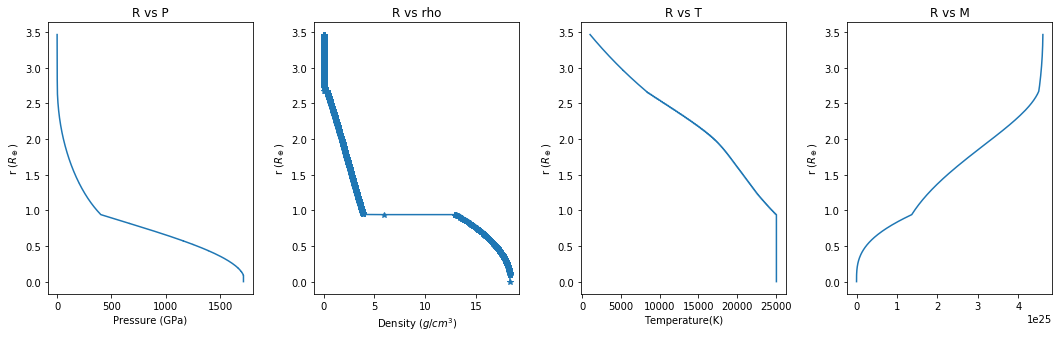

In [66]:
plot_profile(new_planet, 'All')

IndexError: list index out of range

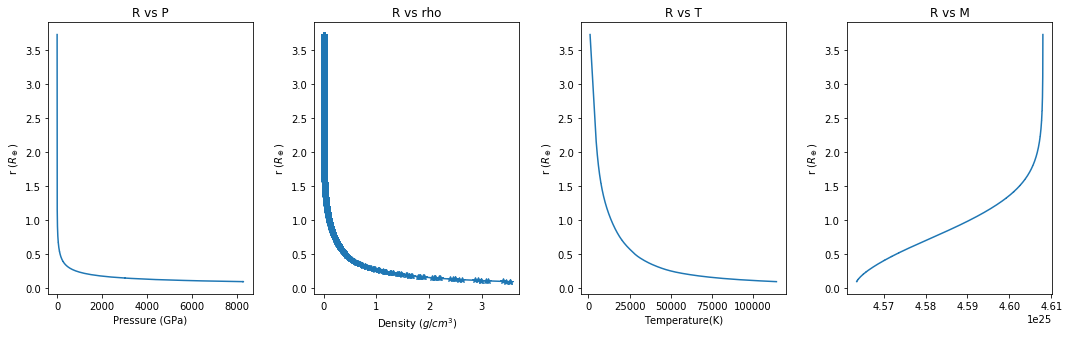

In [270]:
new_planet